In [2]:
#Throughout this document, things that can be changed by the user to investigate different 
#parts of the map are marked with #FINDME

# Import functions
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import eigencurves
import eigenmaps
import kmeans
import bin_eigenspectra
import os
import pdb
import spiderman as sp

import gen_lightcurves
import healpy as hp

import colorcet as cc
from colormap2d import generate_map2d
from matplotlib import colorbar, cm
from matplotlib.colors import BoundaryNorm, Normalize
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

import run_higher_sph_harm
from eigensource import plot_utils

from importlib import import_module

import emcee
import corner

In [3]:
# Use prettier plot defaults 
plot_utils.plot_setup()

# Approach 

We elected to create eclipse lightcurves that will test the code along two axes: (1) physically reasonable vs. easily separable for the (2) map and spectra. As a result, we have four tests (think *Punnett square*):

>[**Mystery 1** – Easily separable map with easily separable spectra](#one)   
>[**Mystery 2** – Easily separable map with physically realistic spectra](#two)   
>[**Mystery 3** – Physically realistic map with easily separable spectra](#three)  
>[**Mystery 4** – Physically realistic map with physically realistic spectra](#four)    `

These tests are presented in reverse order below. [Followed by a code to produce figures for the paper](#figures). 

# Parse Files from Kat Feng

In [4]:
file_list = ["h2o_-0.6_beta_0.6.npz", 
             "h2o_-2.0_beta_0.6.npz", 
             "h2o_-5.0_beta_0.6.npz", 
             "h2o_0.0_beta_0.6.npz", 
             "h2o_0.6_beta_0.7.npz", 
             "h2o_1.3_beta_0.7.npz", 
             "h2o_2.0_beta_0.9.npz", 
             "h2o_2.6_beta_0.9.npz", 
             "h2o_3.3_beta_1.0.npz", 
             "h2o_4.0_beta_1.0.npz"]

In [52]:
path = "data/varyH2O/"

In [53]:
data = np.load(os.path.join(path, file_list[0]))

In [54]:
data.files

['wl', 'fpfs']

/Users/Jake/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1339: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/Jake/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1339: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


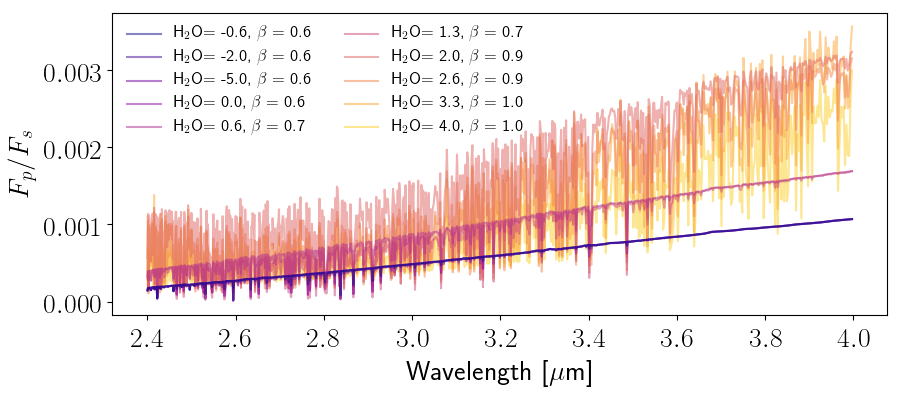

In [8]:
fig, ax = plt.subplots(figsize = (10,4))
ax.set_xlabel(r"Wavelength [$\mu$m]")
ax.set_ylabel("$F_p/ F_s$")

COLORS = plt.cm.plasma(np.arange(len(file_list)) / float(len(file_list)))

for i in range(len(file_list)):
    
    data = np.load(os.path.join(path, file_list[i]))

    ax.plot(data["wl"], data["fpfs"], alpha = 0.5, color = COLORS[i], zorder = len(file_list) - i, label = "%s" %file_list[i].replace("_", " ").replace(".npz", "").replace("h2o", r"H$_2$O=").replace(" beta", r", $\beta=$"))
    
data = np.load(os.path.join(path, file_list[0]))
#ax.plot(data["wl"], data["fpfs"], alpha = 1.0)

data = np.load(os.path.join(path, file_list[-1]))
#ax.plot(data["wl"], data["fpfs"], alpha = 1.0)

ax.legend(ncol = 2, fontsize = 12, framealpha = 0.0)

# Mystery 4: Physical map and spectra <a id='four'></a>
Hotspot gradient map with spectra varying water abundance and beta parameter radially

In [9]:
# Create 2d array of spectra
Fgrad = []
for i in range(len(file_list)):
    data = np.load(os.path.join(path, file_list[i]))
    Fgrad.append(data["fpfs"])
Fgrad = np.array(Fgrad)[::-1, :]
wl = data["wl"]

In [10]:
# Check dimensions
print(Fgrad.shape)
print(wl.shape)

(10, 833)
(833,)


# Create an evil gradient hot spot map

In [11]:
def prep_gradient_hotspot_map(lamhr, Fgrad, phi0 = np.pi, theta0 = 0.0, ds = 25.0,
                              Nside = 16):
    """
    Generate a toy spaxel map with a hotspot

    Parameters
    ----------
    lamhr : numpy.array
        Wavelength grid
    Fgrad : numpy.ndarray
        2D array of spectra [unique, wavelength]
    phi0 : float
        Latitude of hot spot center [radians]
    theta0 : float
        Longitude of hot spot center [radians]
    ds : float
        Angular radius of hotspot [degrees]

    Returns
    -------
    lamhr : numpy.array
        Wavelength grid [microns]
    spaxels : numpy.ndarray
        Pixel spectra (2d)

    Example
    -------
    >>> lam, spaxels = prep_spectral_hotspot_map()
    """
    
    # Get number of unique spectra provided
    Nspec = Fgrad.shape[0]
    
    # Determine angular width of each slice as the user provided hotspot width divided 
    # by the number of unique spectra
    ds_slice = ds / Nspec

    # Get number of pixels/spaxels
    Npix = hp.nside2npix(Nside)

    # Calc the latitude and longitude of each hpix
    thetas, phis = hp.pix2ang(Nside, np.arange(Npix))
    thetas = thetas - np.pi / 2
    phis = phis - np.pi

    # Define empty 2d array for spaxels
    Nlam = len(lamhr)
    spaxels = np.zeros((Npix, Nlam))

    # Loop over pixels filling with blackbody
    for i in range(hp.nside2npix(Nside)):

        # Relabel variables for below equation
        phi1, theta1 =  thetas[i], phis[i]
        dtheta = theta0 - theta1

        # Calculate the angular distance between two points on sphere
        ang = np.arccos(np.sin(phi1) * np.sin(phi0) + np.cos(phi1) * np.cos(phi0) * np.cos(dtheta)) * 180 / np.pi

        # Loop over rings 
        for j in range(Nspec):
            
            # If the pixel is in the i-th ring
            if (ang > ds_slice*(j)) and (ang < ds_slice*(j+1)):
                
                # Set the spectrum
                spaxels[i,:] = Fgrad[j,:]
                
            elif (ang > ds_slice*Nspec):
                
                # Set the spectrum as the last spectrum
                spaxels[i,:] = Fgrad[-1,:]

    return lamhr, spaxels

In [12]:
# Start with a simple test, Ftest
Ftest = []
for i in range(Fgrad.shape[0]):
    Ftest.append(i*np.ones_like(wl))
Ftest = np.array(Ftest)

In [13]:
# Create high res spectral map
lamhr, spaxels = prep_gradient_hotspot_map(wl, Fgrad, ds = 89.0, Nside=64)

/Users/Jake/anaconda2/envs/py3/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


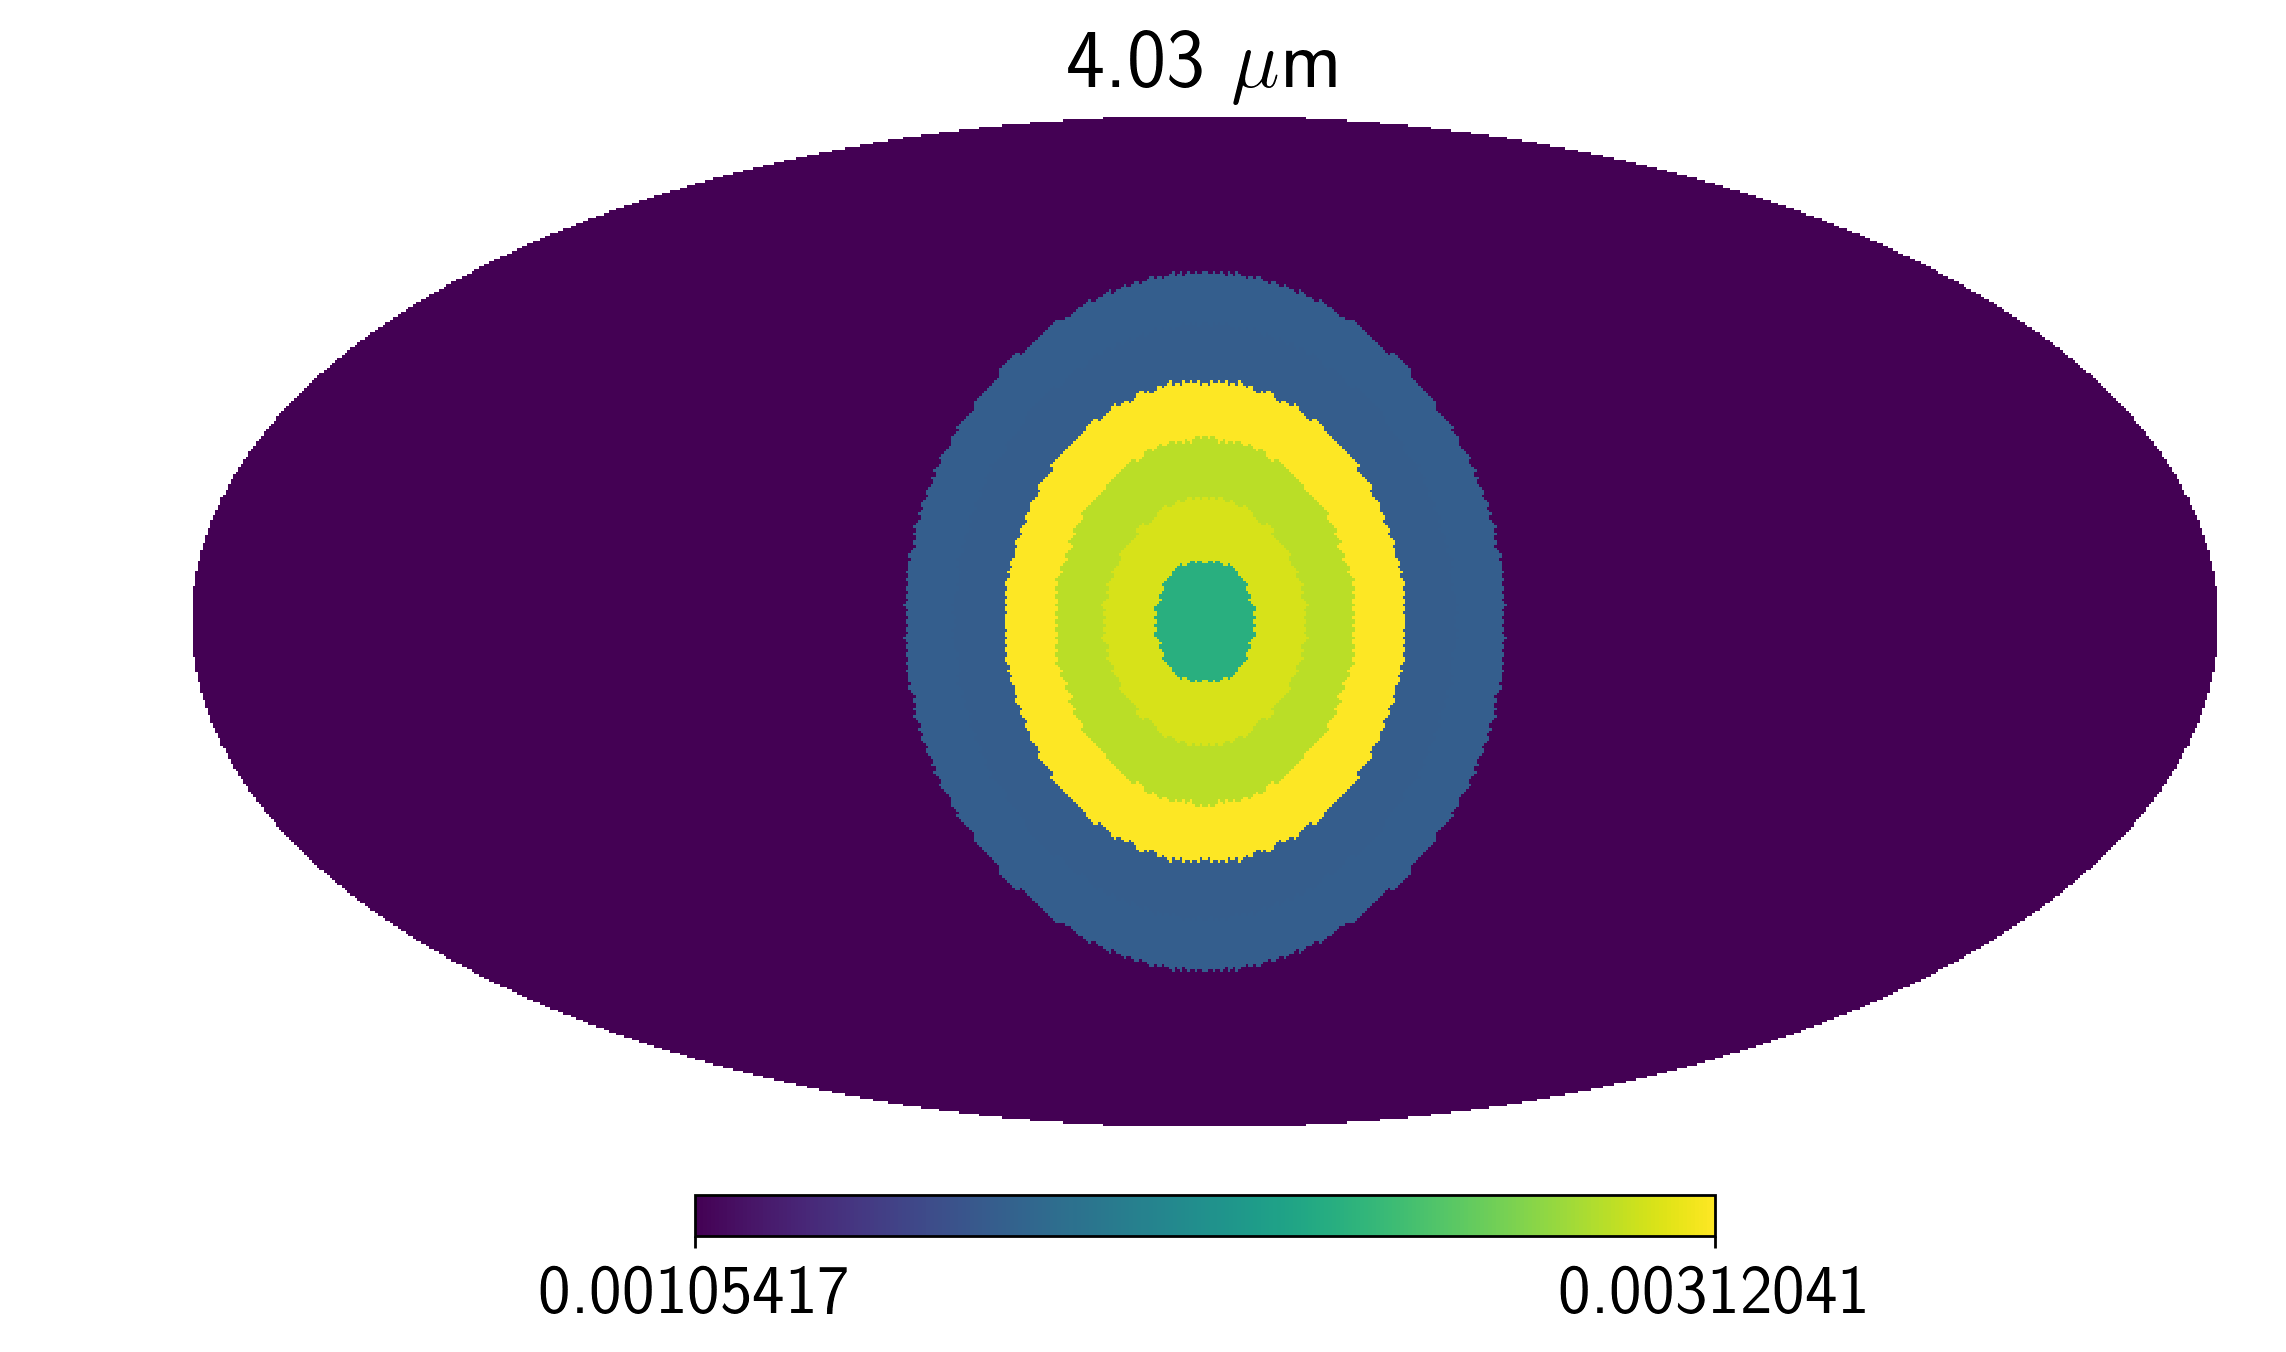

In [73]:
# Show the map
plot_utils.show_orig_map(lamhr, spaxels, waveInd=-1);

/Users/Jake/anaconda2/envs/py3/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


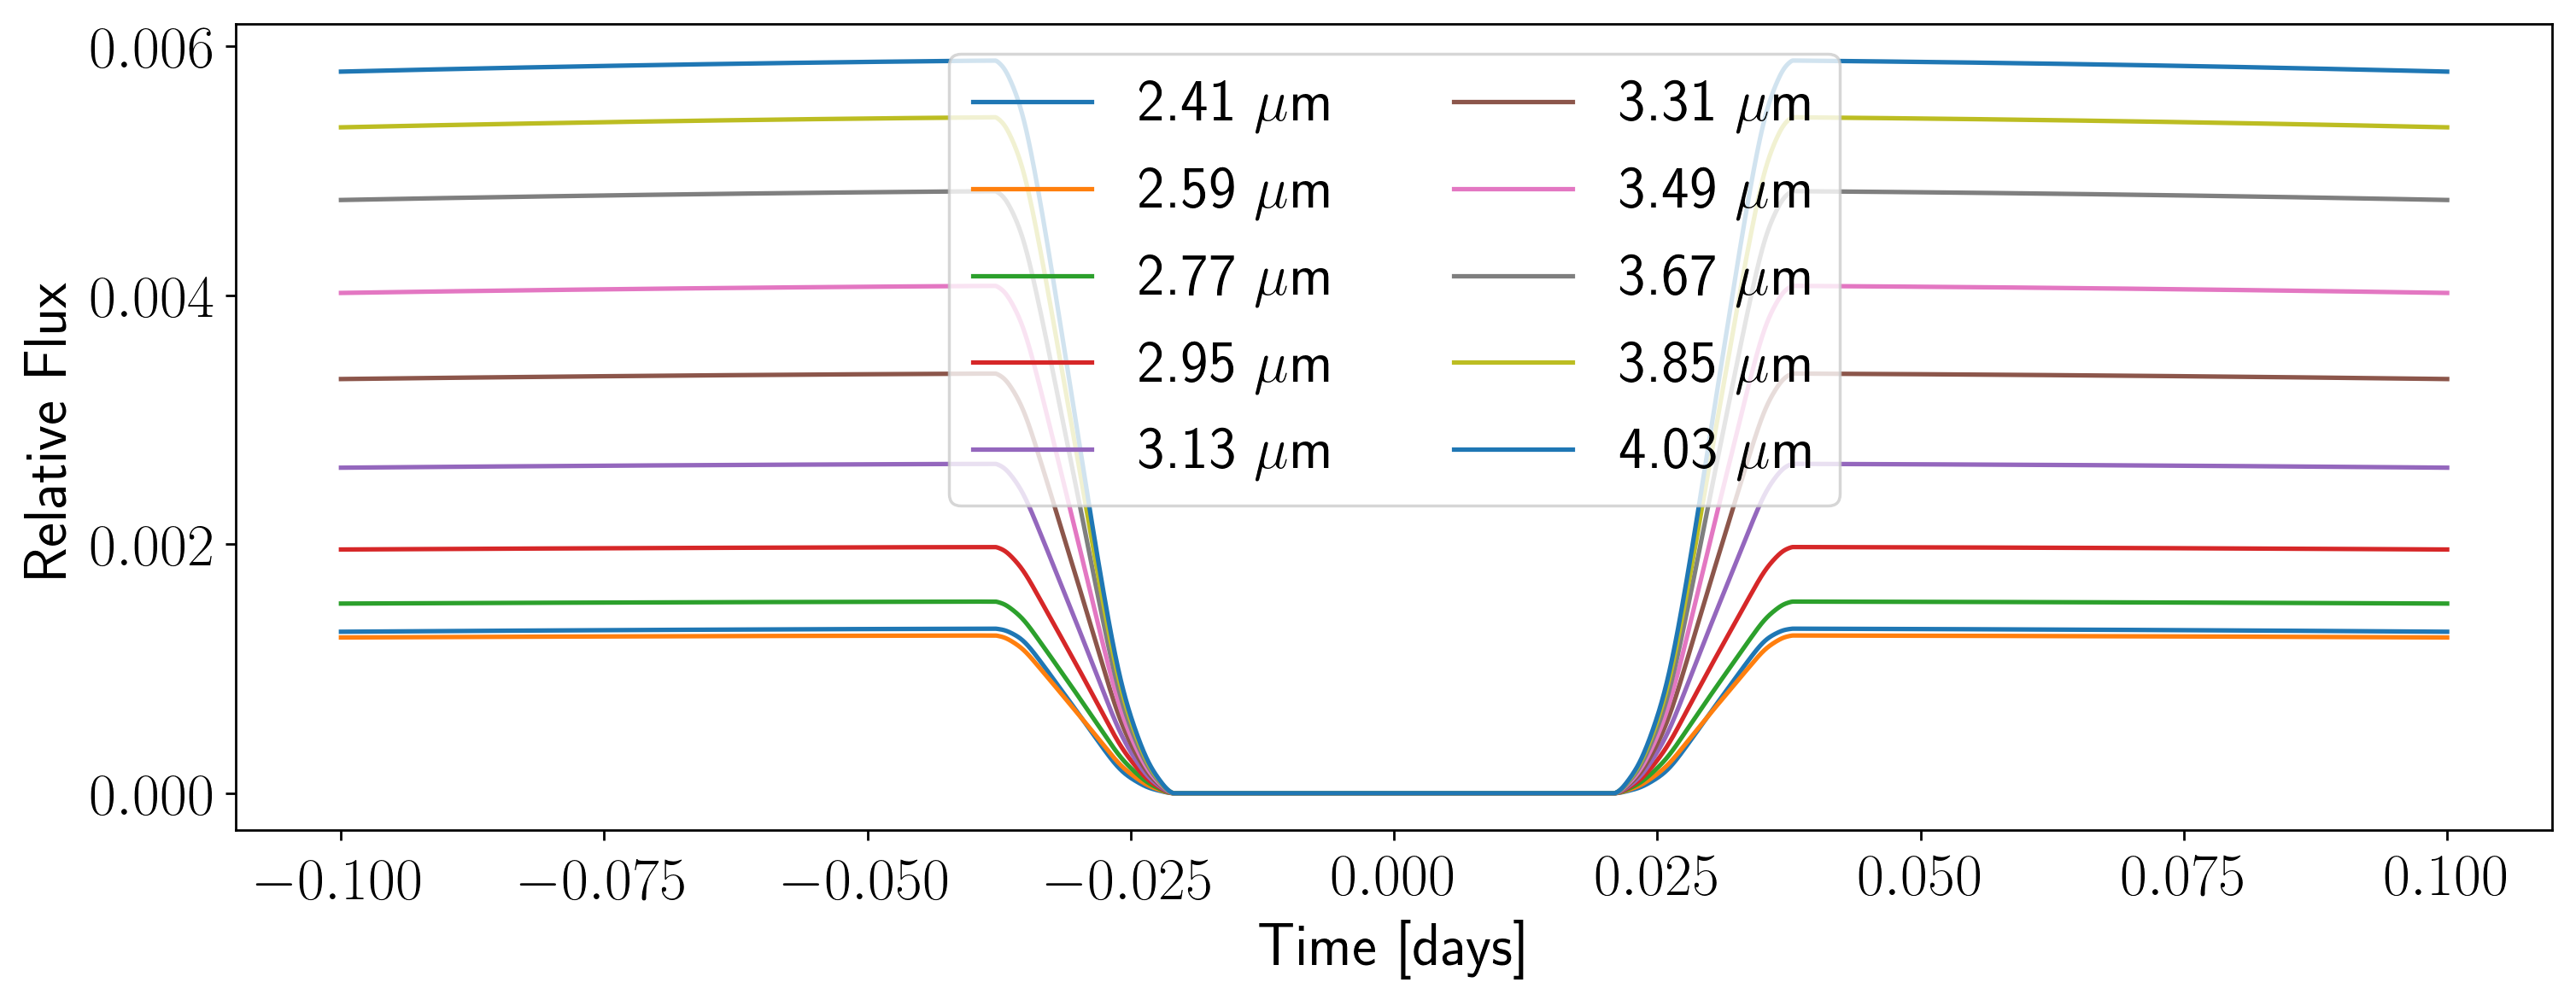

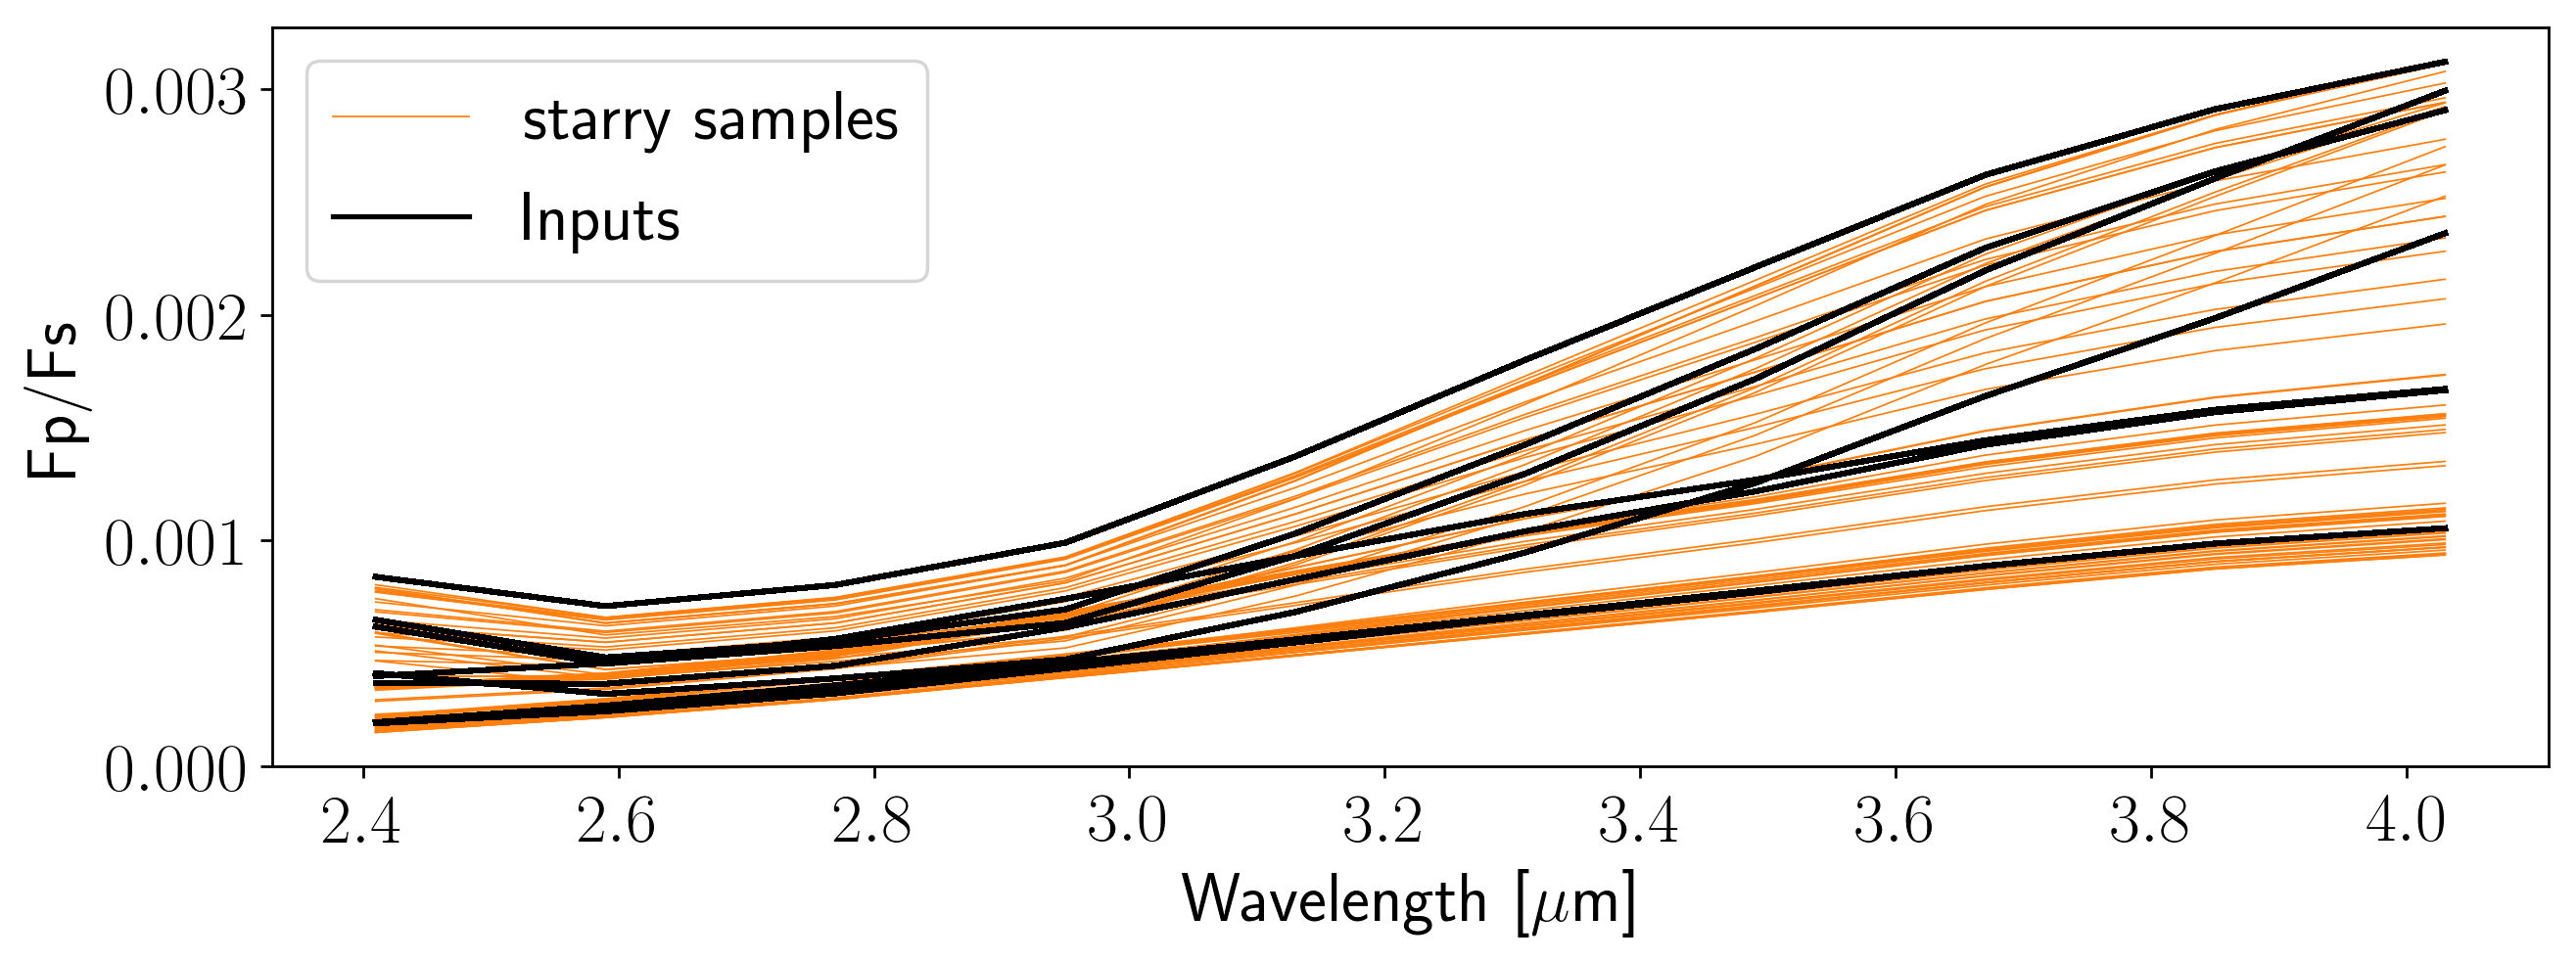

In [74]:
# Create the eclipse lightcurves
time, lam, dlam, lcurves = gen_lightcurves.create_lightcurves_with_starry(lamhr, spaxels, save_tag = "mystery4", save_output=True)

# Mystery 3: Physical map, unphysical spectra <a id='three'></a>

Hot spot gradient map with easier to separate spectra that vary continuum level, absorption strength, absorption width

In [14]:
Nspec = 10 # len(Ngrad)

As = np.linspace(0.003, 0.001, Nspec)
Bs = -As
stds = 0.04 * np.ones_like(As)
xrolls = np.linspace(-0.35, 0.35, Nspec)

Ftoy = []
for i in range(Nspec):
    fpfsi = gen_lightcurves.spec_flat_with_gaussian(lamhr, A = As[i], B = Bs[i], std = stds[i], xroll = xrolls[i])
    Ftoy.append(fpfsi)
Ftoy = np.array(Ftoy)

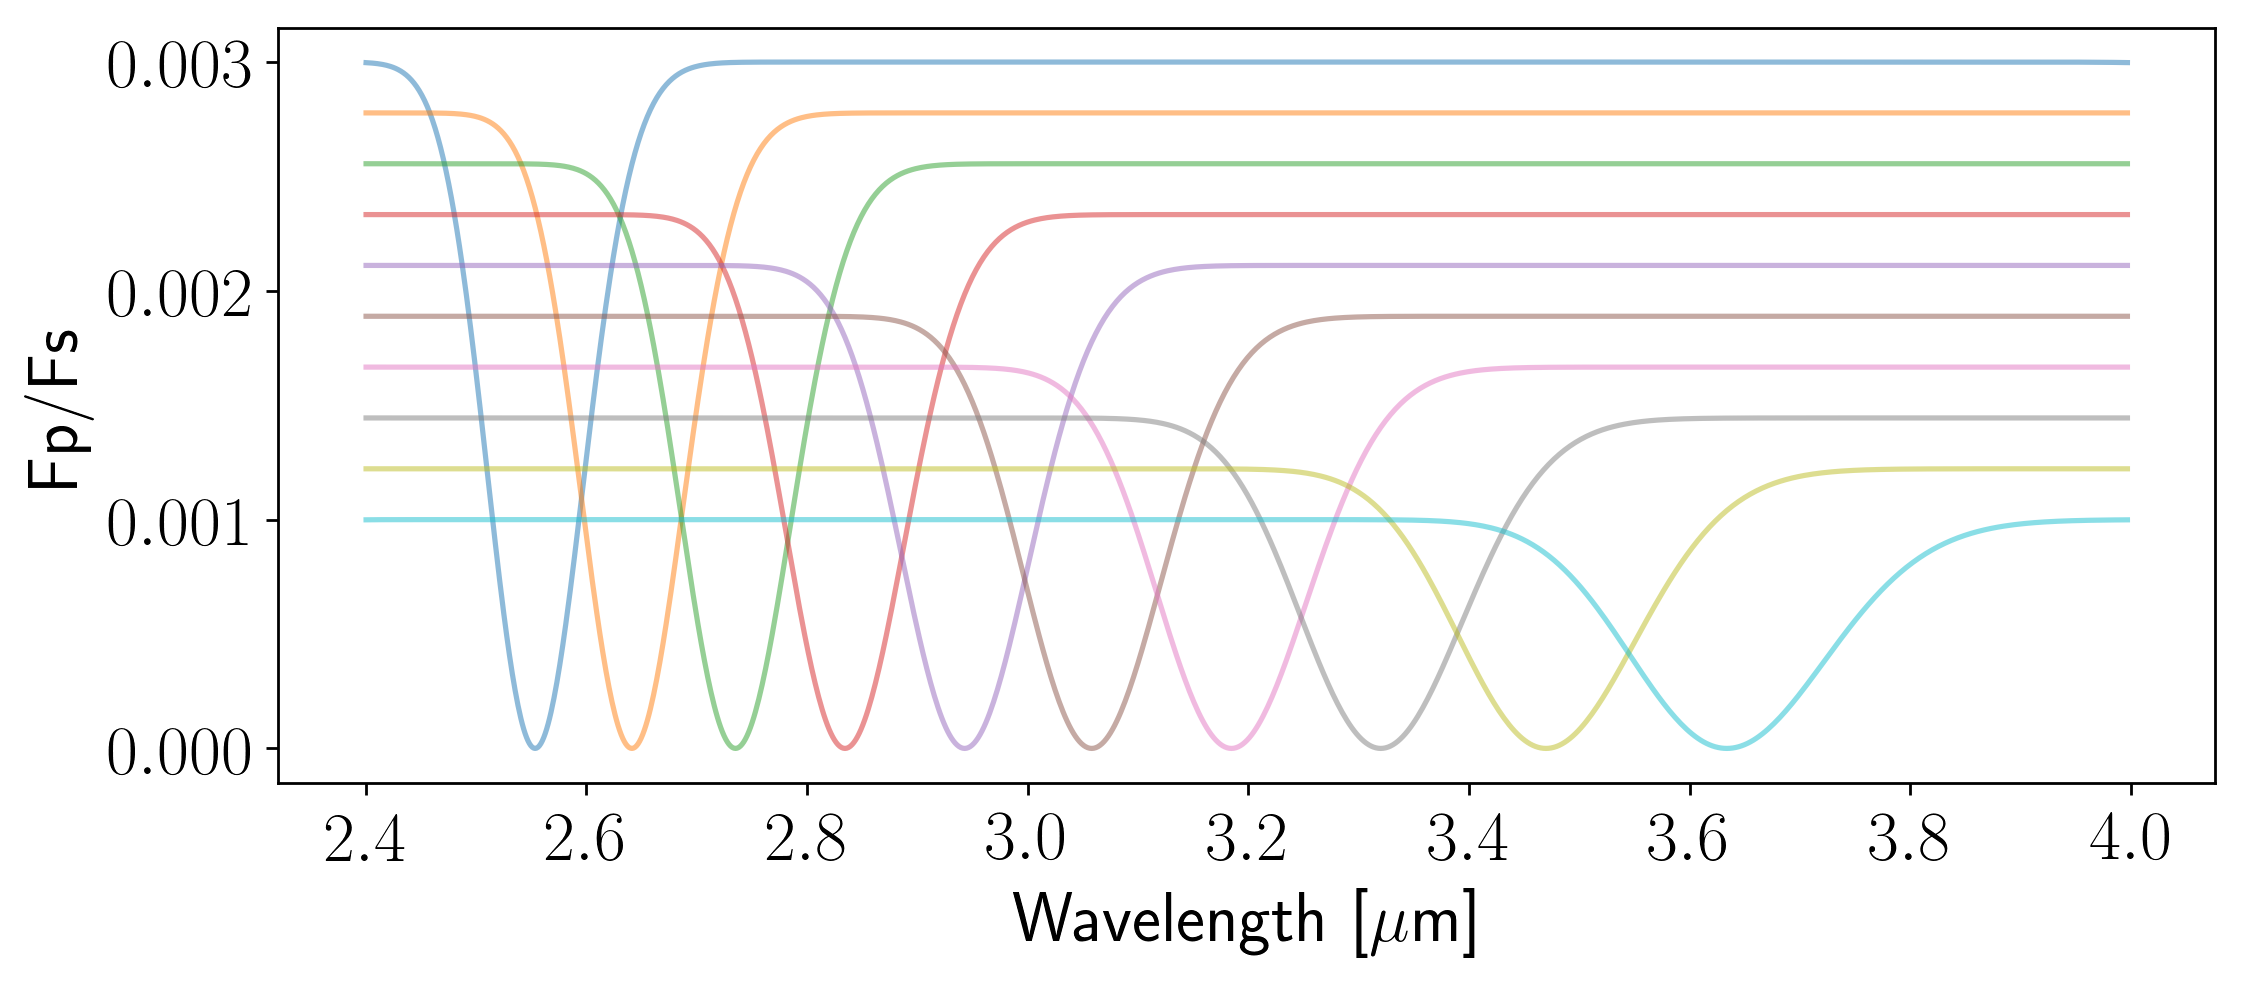

In [15]:
fig, ax = plt.subplots(figsize = (10,4))
ax.set_xlabel(r"Wavelength [$\mu$m]")
ax.set_ylabel("Fp/Fs")

for i in range(Nspec):

    ax.plot(lamhr, Ftoy[i,:], alpha = 0.5)

In [116]:
# Create high res spectral map
lamhr, spaxels = prep_gradient_hotspot_map(wl, Ftoy, ds = 89.0, Nside=64)

/Users/Jake/anaconda2/envs/py3/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


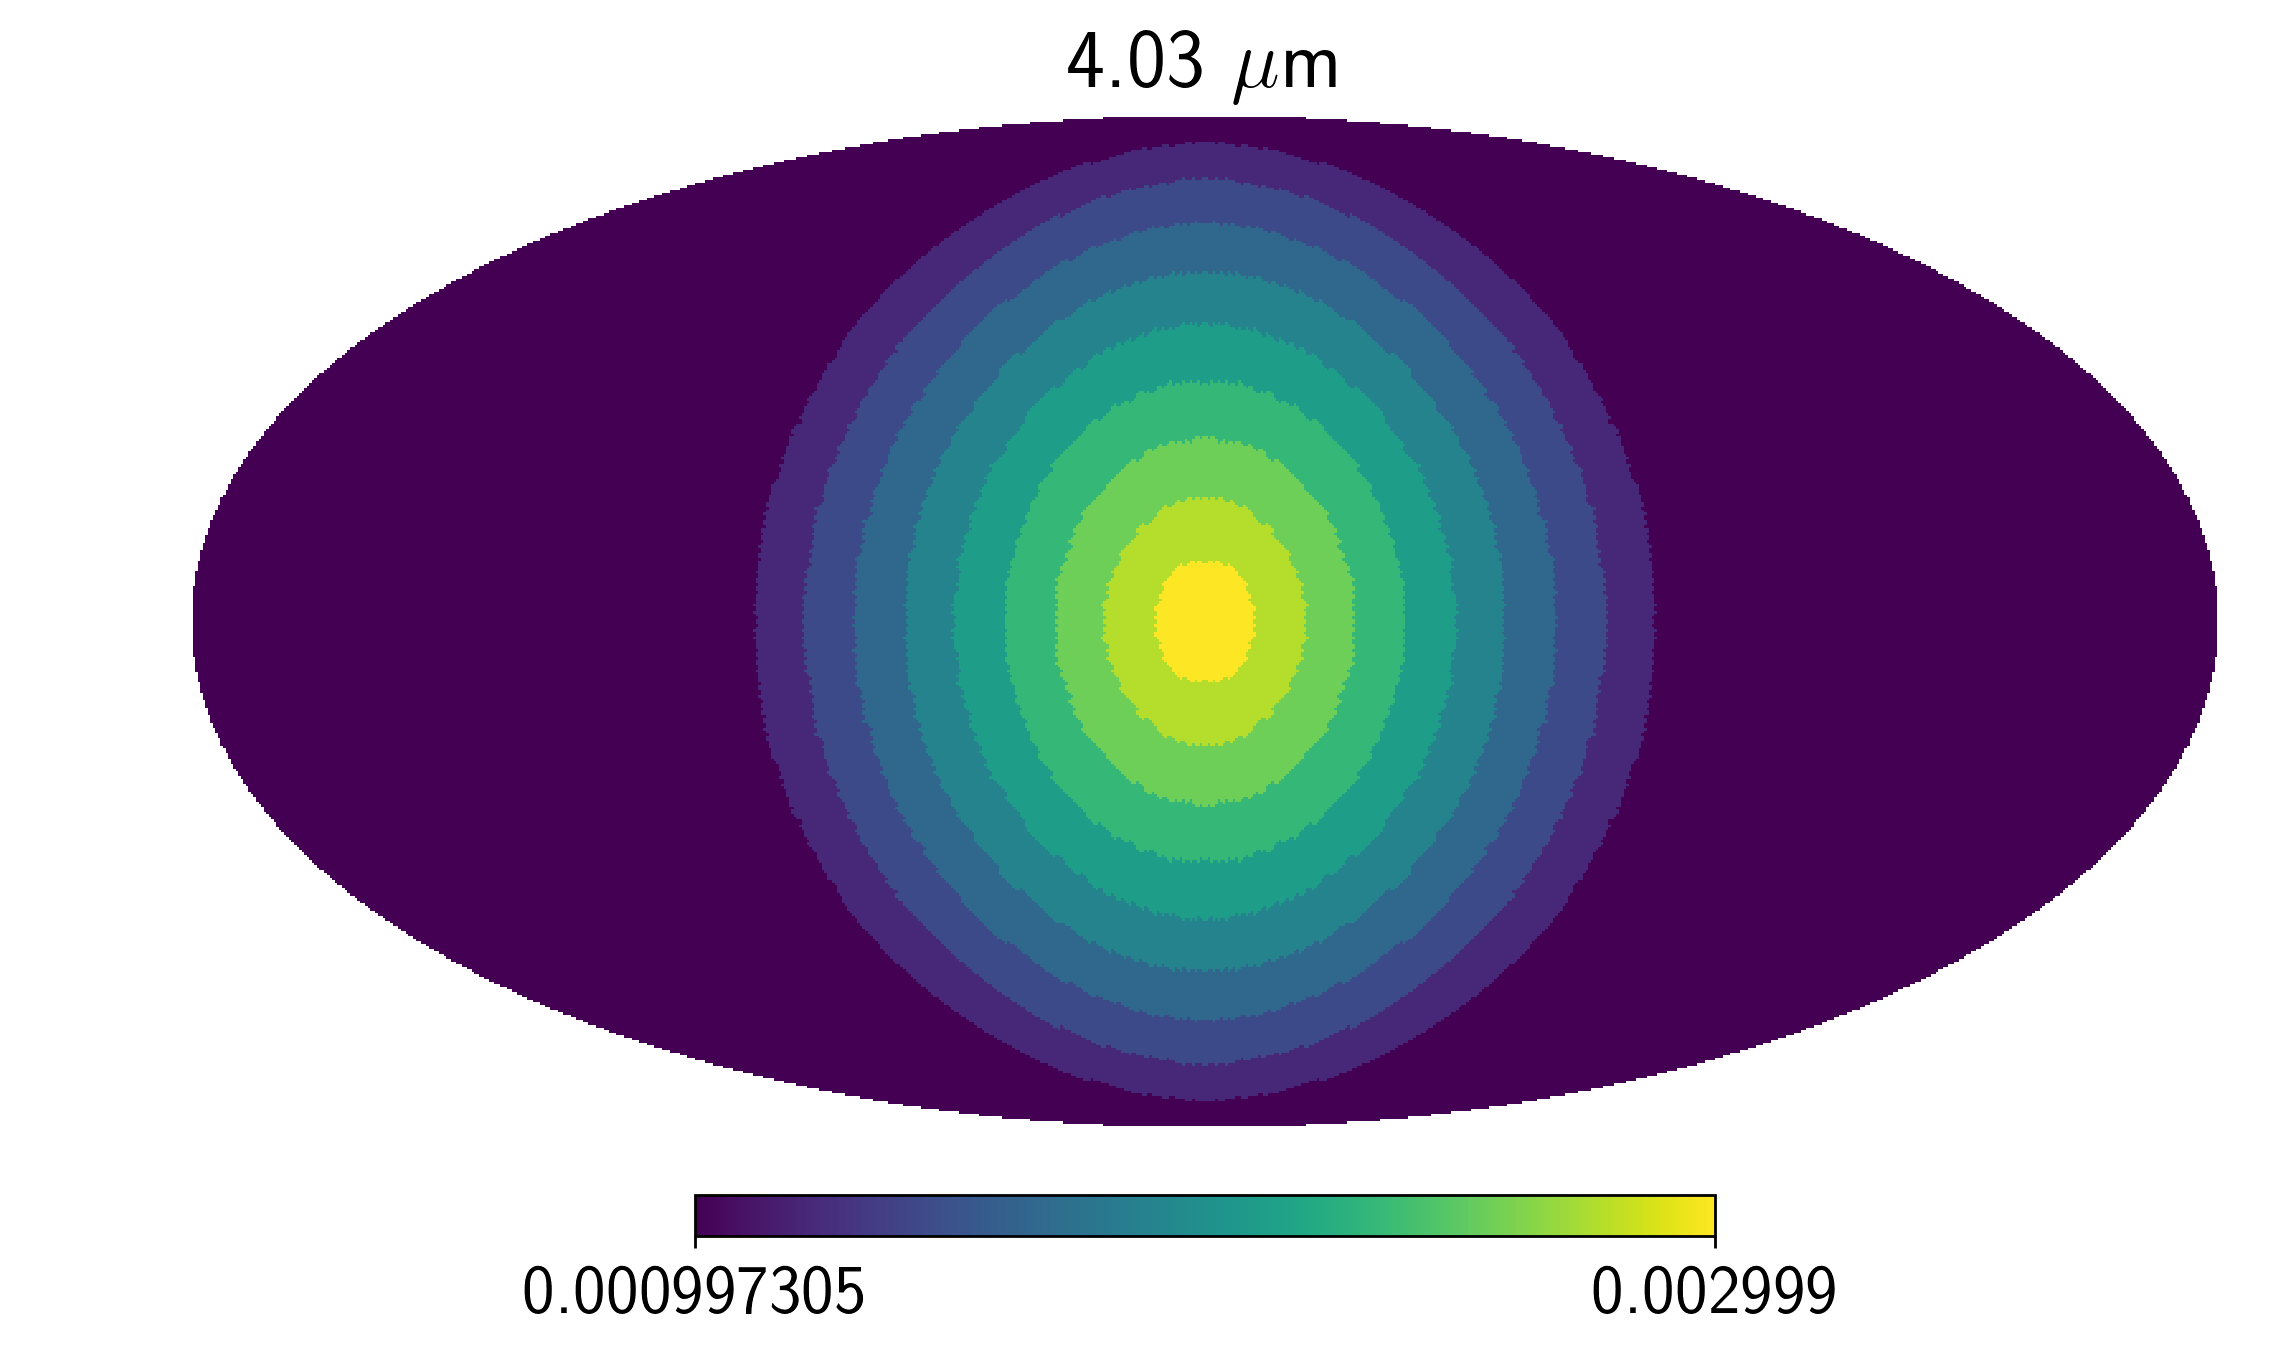

In [118]:
# Show the map
plot_utils.show_orig_map(lamhr, spaxels, waveInd=-1);

/Users/Jake/anaconda2/envs/py3/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


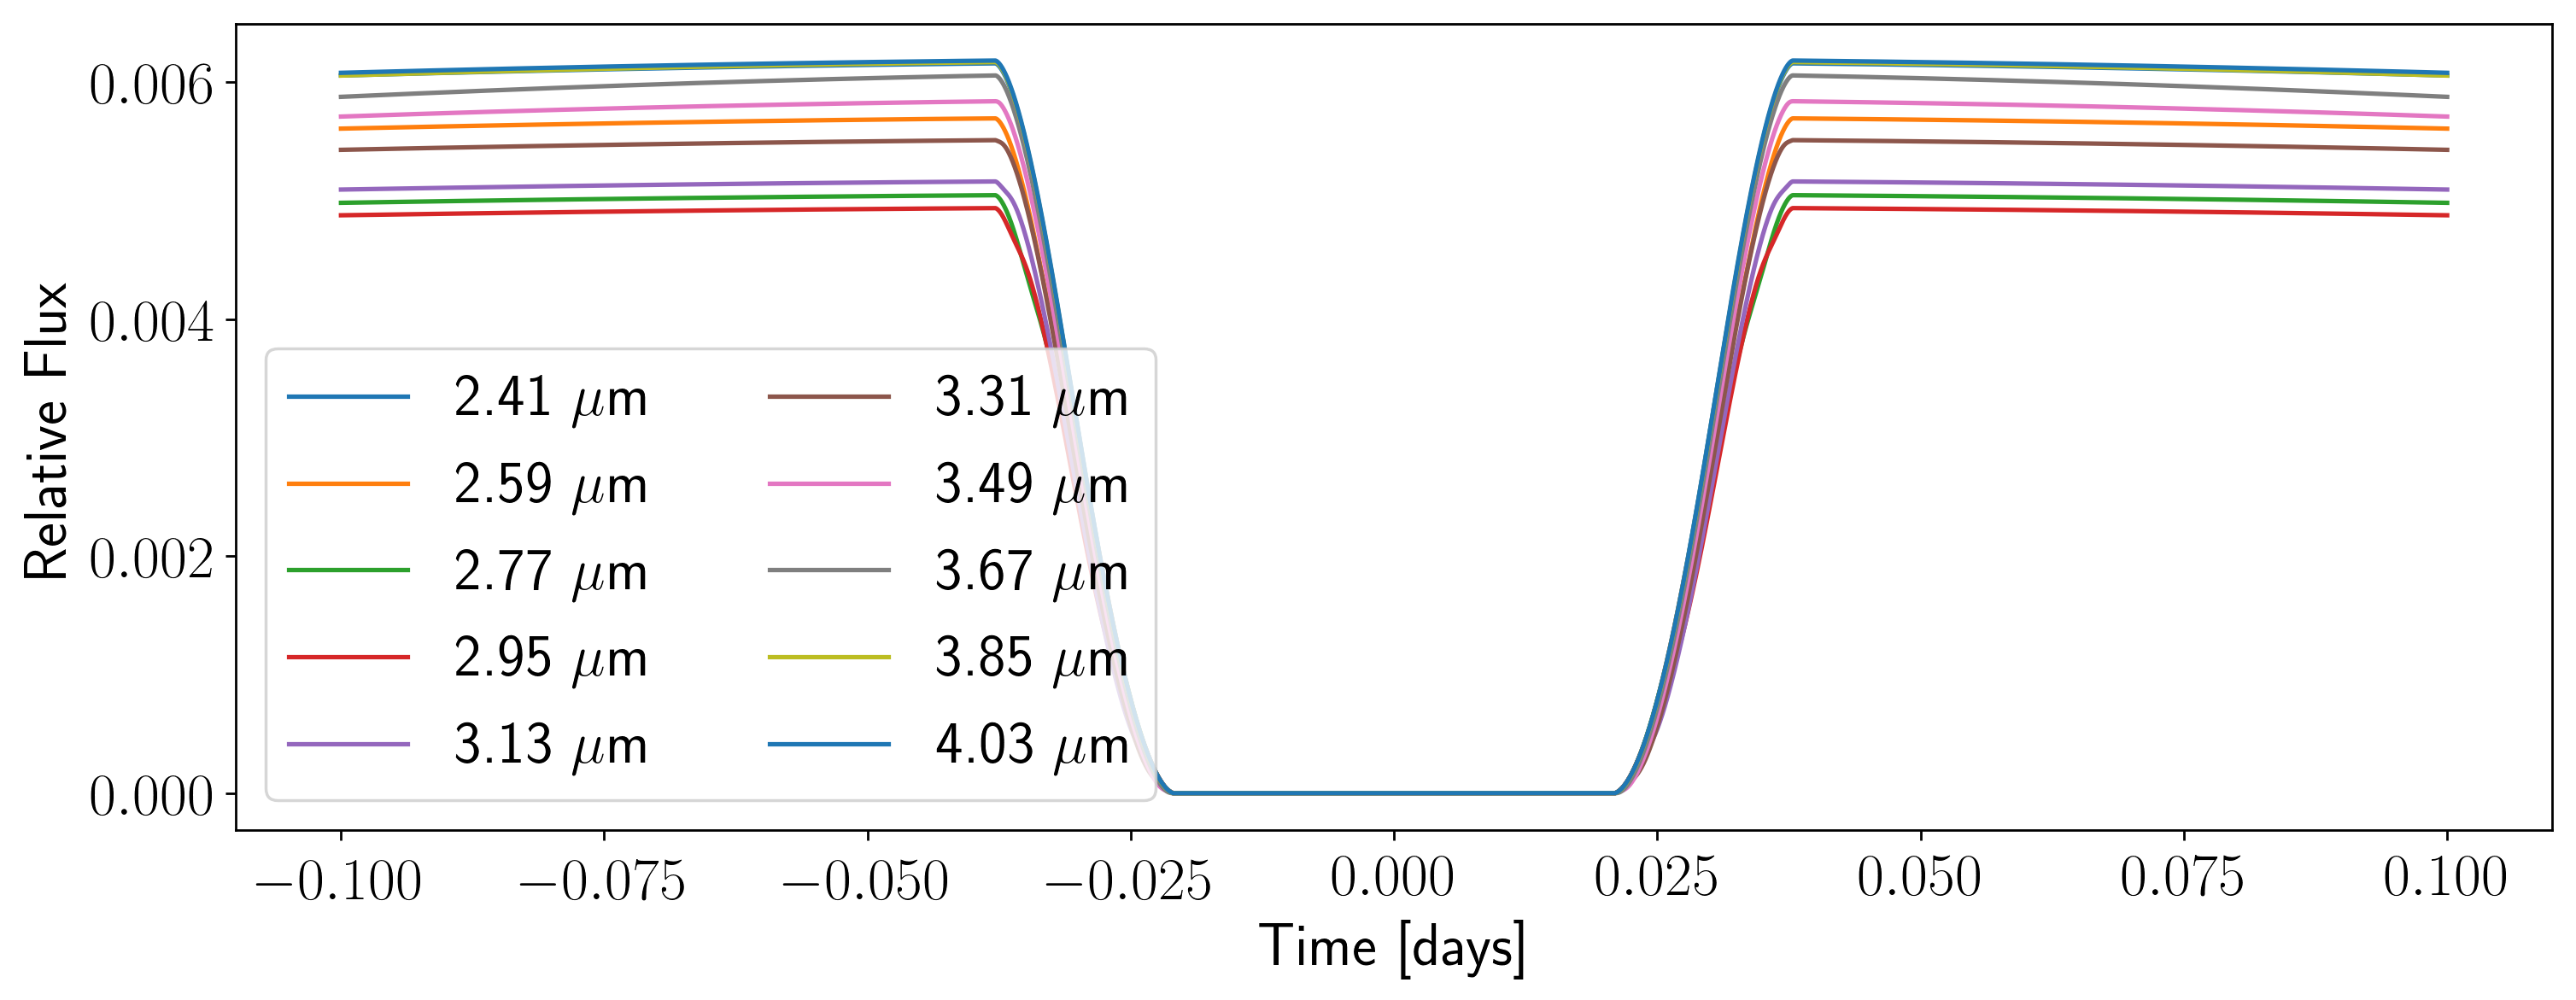

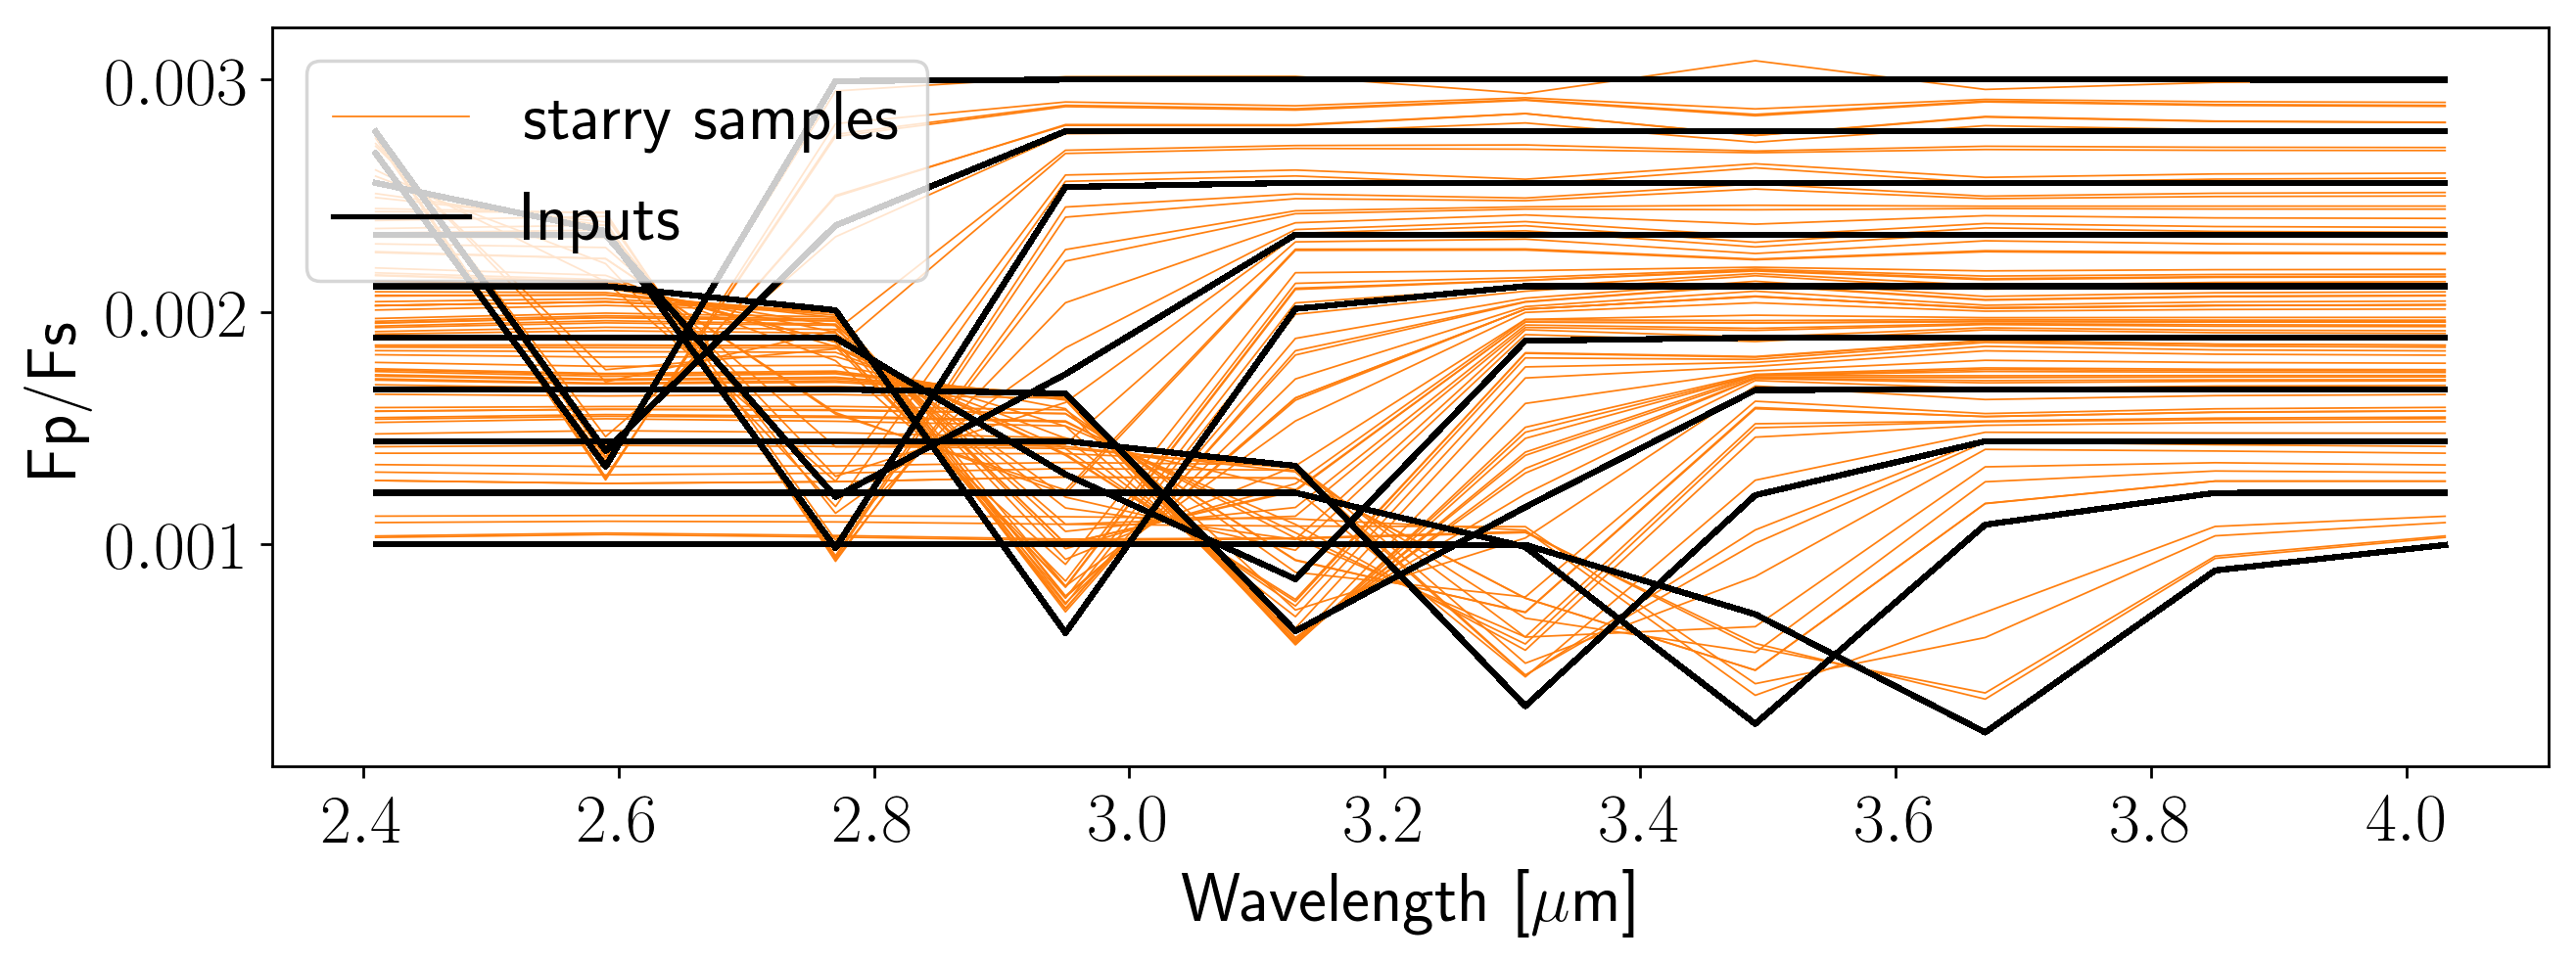

In [119]:
# Create the eclipse lightcurves
time, lam, dlam, lcurves = gen_lightcurves.create_lightcurves_with_starry(lamhr, spaxels, save_tag = "mystery3", save_output=True)

# Mystery 2: Unphysical map, physical spectra <a id='two'></a>

Two-component map with offset hot spot in lat and lon, with the end-member water/beta spectra

In [16]:
def prep_two_component_hotspot_map(F_in, F_out, phi0 = np.pi, theta0 = 0.0, ds = 25.0,
                                   Nside = 16):
    """
    Generate a toy spaxel map with a hotspot

    Parameters
    ----------
    phi0 : float
        Latitude of hot spot center [radians]
    theta0 : float
        Longitude of hot spot center [radians]
    ds : float
        Angular radius of hotspot [degrees]

    Returns
    -------
    lamhr : numpy.array
        Wavelength grid [microns]
    spaxels : numpy.ndarray
        Pixel spectra (2d)

    Example
    -------
    >>> lam, spaxels = prep_spectral_hotspot_map()
    """
    
    assert len(F_out) == len(F_in)

    # Outside hotspot
    FpFs1 = F_out

    # Inside hotspot
    FpFs2 = F_in

    # Get number of pixels/spaxels
    Npix = hp.nside2npix(Nside)

    # Calc the latitude and longitude of each hpix
    thetas, phis = hp.pix2ang(Nside, np.arange(Npix))
    thetas = thetas - np.pi / 2
    phis = phis - np.pi

    # Define empty 2d array for spaxels
    Nlam = len(F_in)
    spaxels = np.zeros((Npix, Nlam))

    # Loop over pixels filling with blackbody
    for i in range(hp.nside2npix(Nside)):

        # Relabel variables for below equation
        phi1, theta1 =  thetas[i], phis[i]
        dtheta = theta0 - theta1

        # Calculate the angular distance between two points on sphere
        ang = np.arccos(np.sin(phi1) * np.sin(phi0) + np.cos(phi1) * np.cos(phi0) * np.cos(dtheta)) * 180 / np.pi

        # Use a different spectrum inside and outside of the great circle defined by dang
        if ang > ds:
            # Outside hotspot
            spaxels[i,:] = FpFs1
        else:
            # Within hotspot
            spaxels[i,:] = FpFs2

    return spaxels

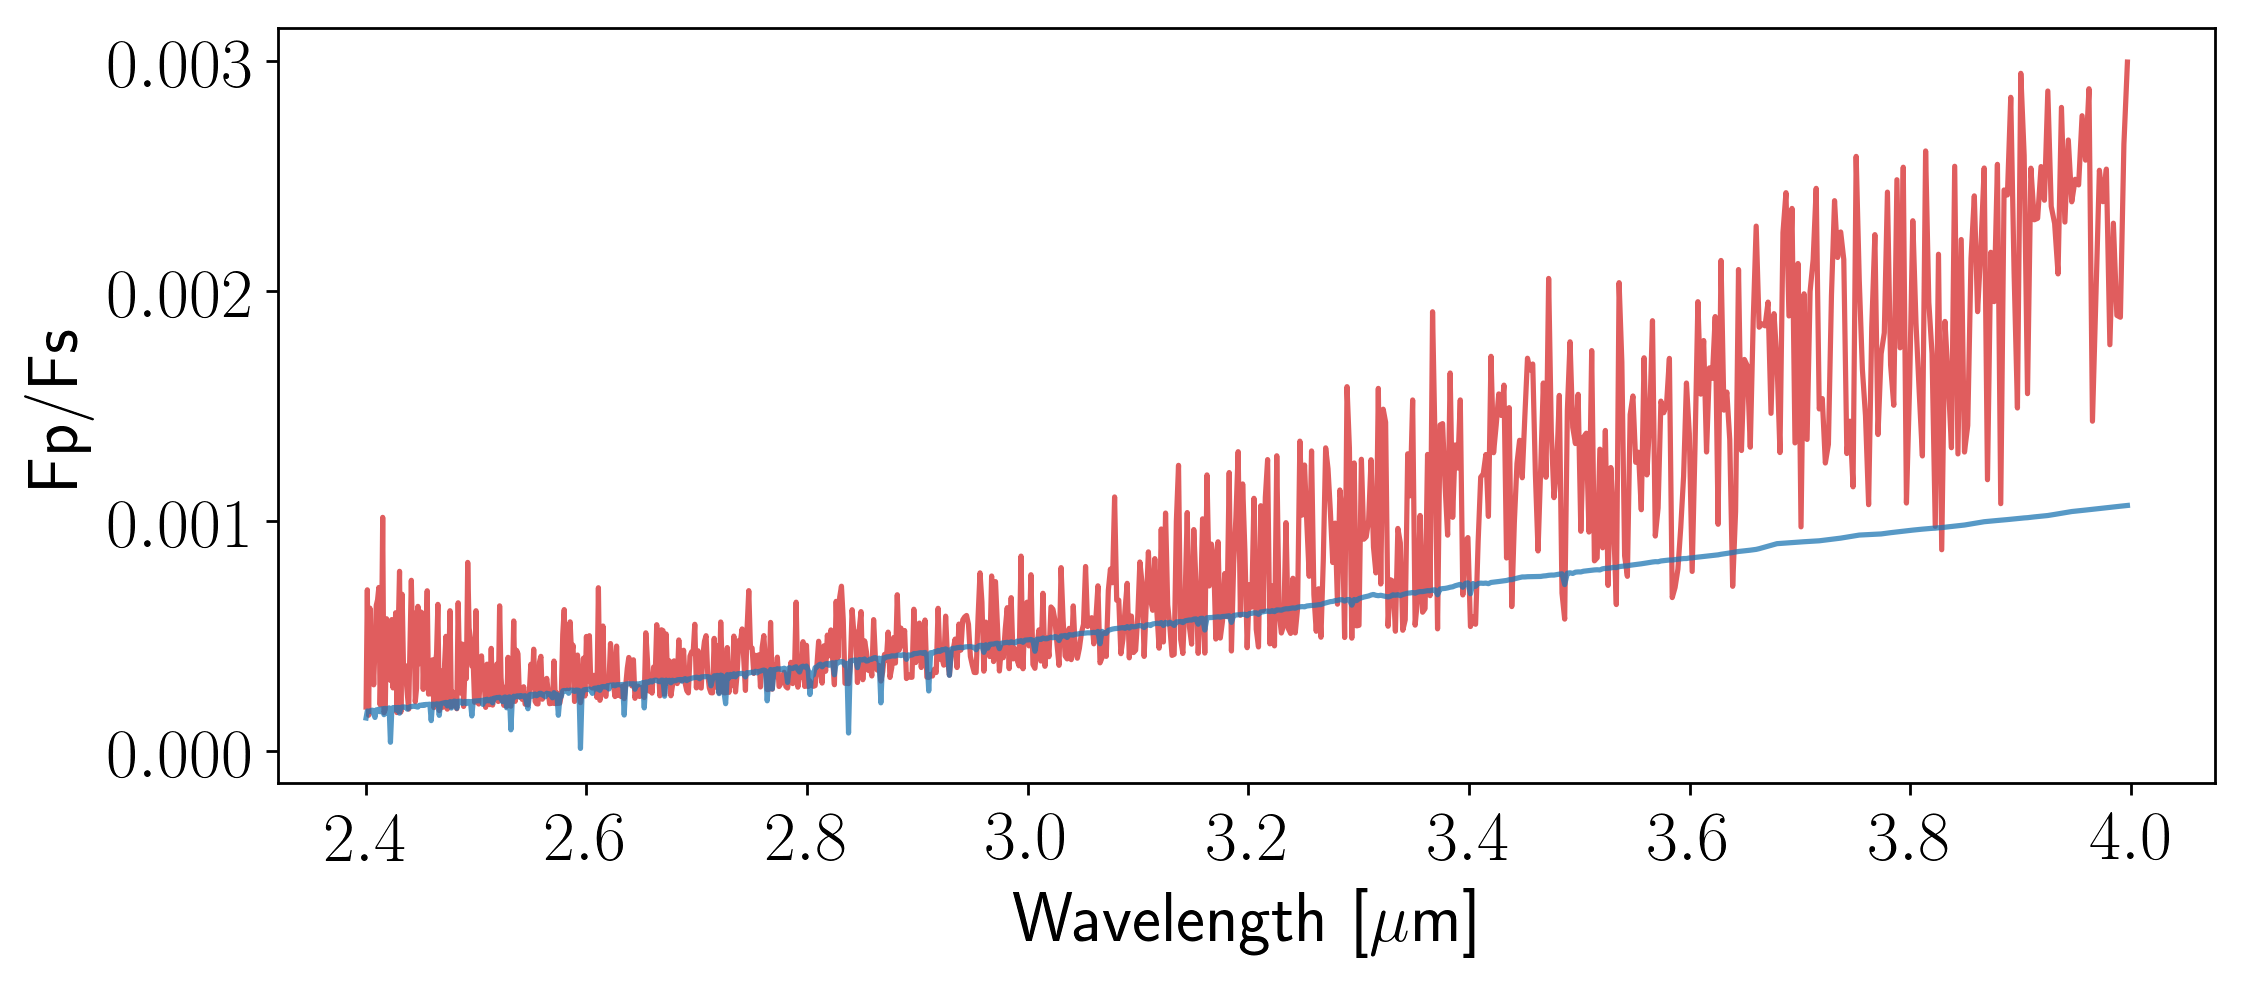

In [28]:
# Use physical spectra edge cases as the interior and exterior hot spot spectra
F_out = Fgrad[0,:]
F_in = Fgrad[-1,:]

fig, ax = plt.subplots(figsize = (10,4))
ax.set_xlabel(r"Wavelength [$\mu$m]")
ax.set_ylabel("$F_p / F_s$")

ax.plot(lamhr, F_in, alpha = 0.75, color = "C3")
ax.plot(lamhr, F_out, alpha = 0.75, color = "C0")

In [29]:
# Set the hotspot offset
lat0 = 45.0
lon0 = 30.0
phi0 = (lat0+180)*(np.pi / 180.) 
theta0 = lon0*(np.pi / 180.)

# Set the angular radius of the hotspot
ds = 30.0

# Create high res spectral map
spaxels = prep_two_component_hotspot_map(F_in, F_out, Nside=64, phi0=phi0, theta0=theta0, ds=30.0)

/Users/Jake/anaconda2/envs/py3/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


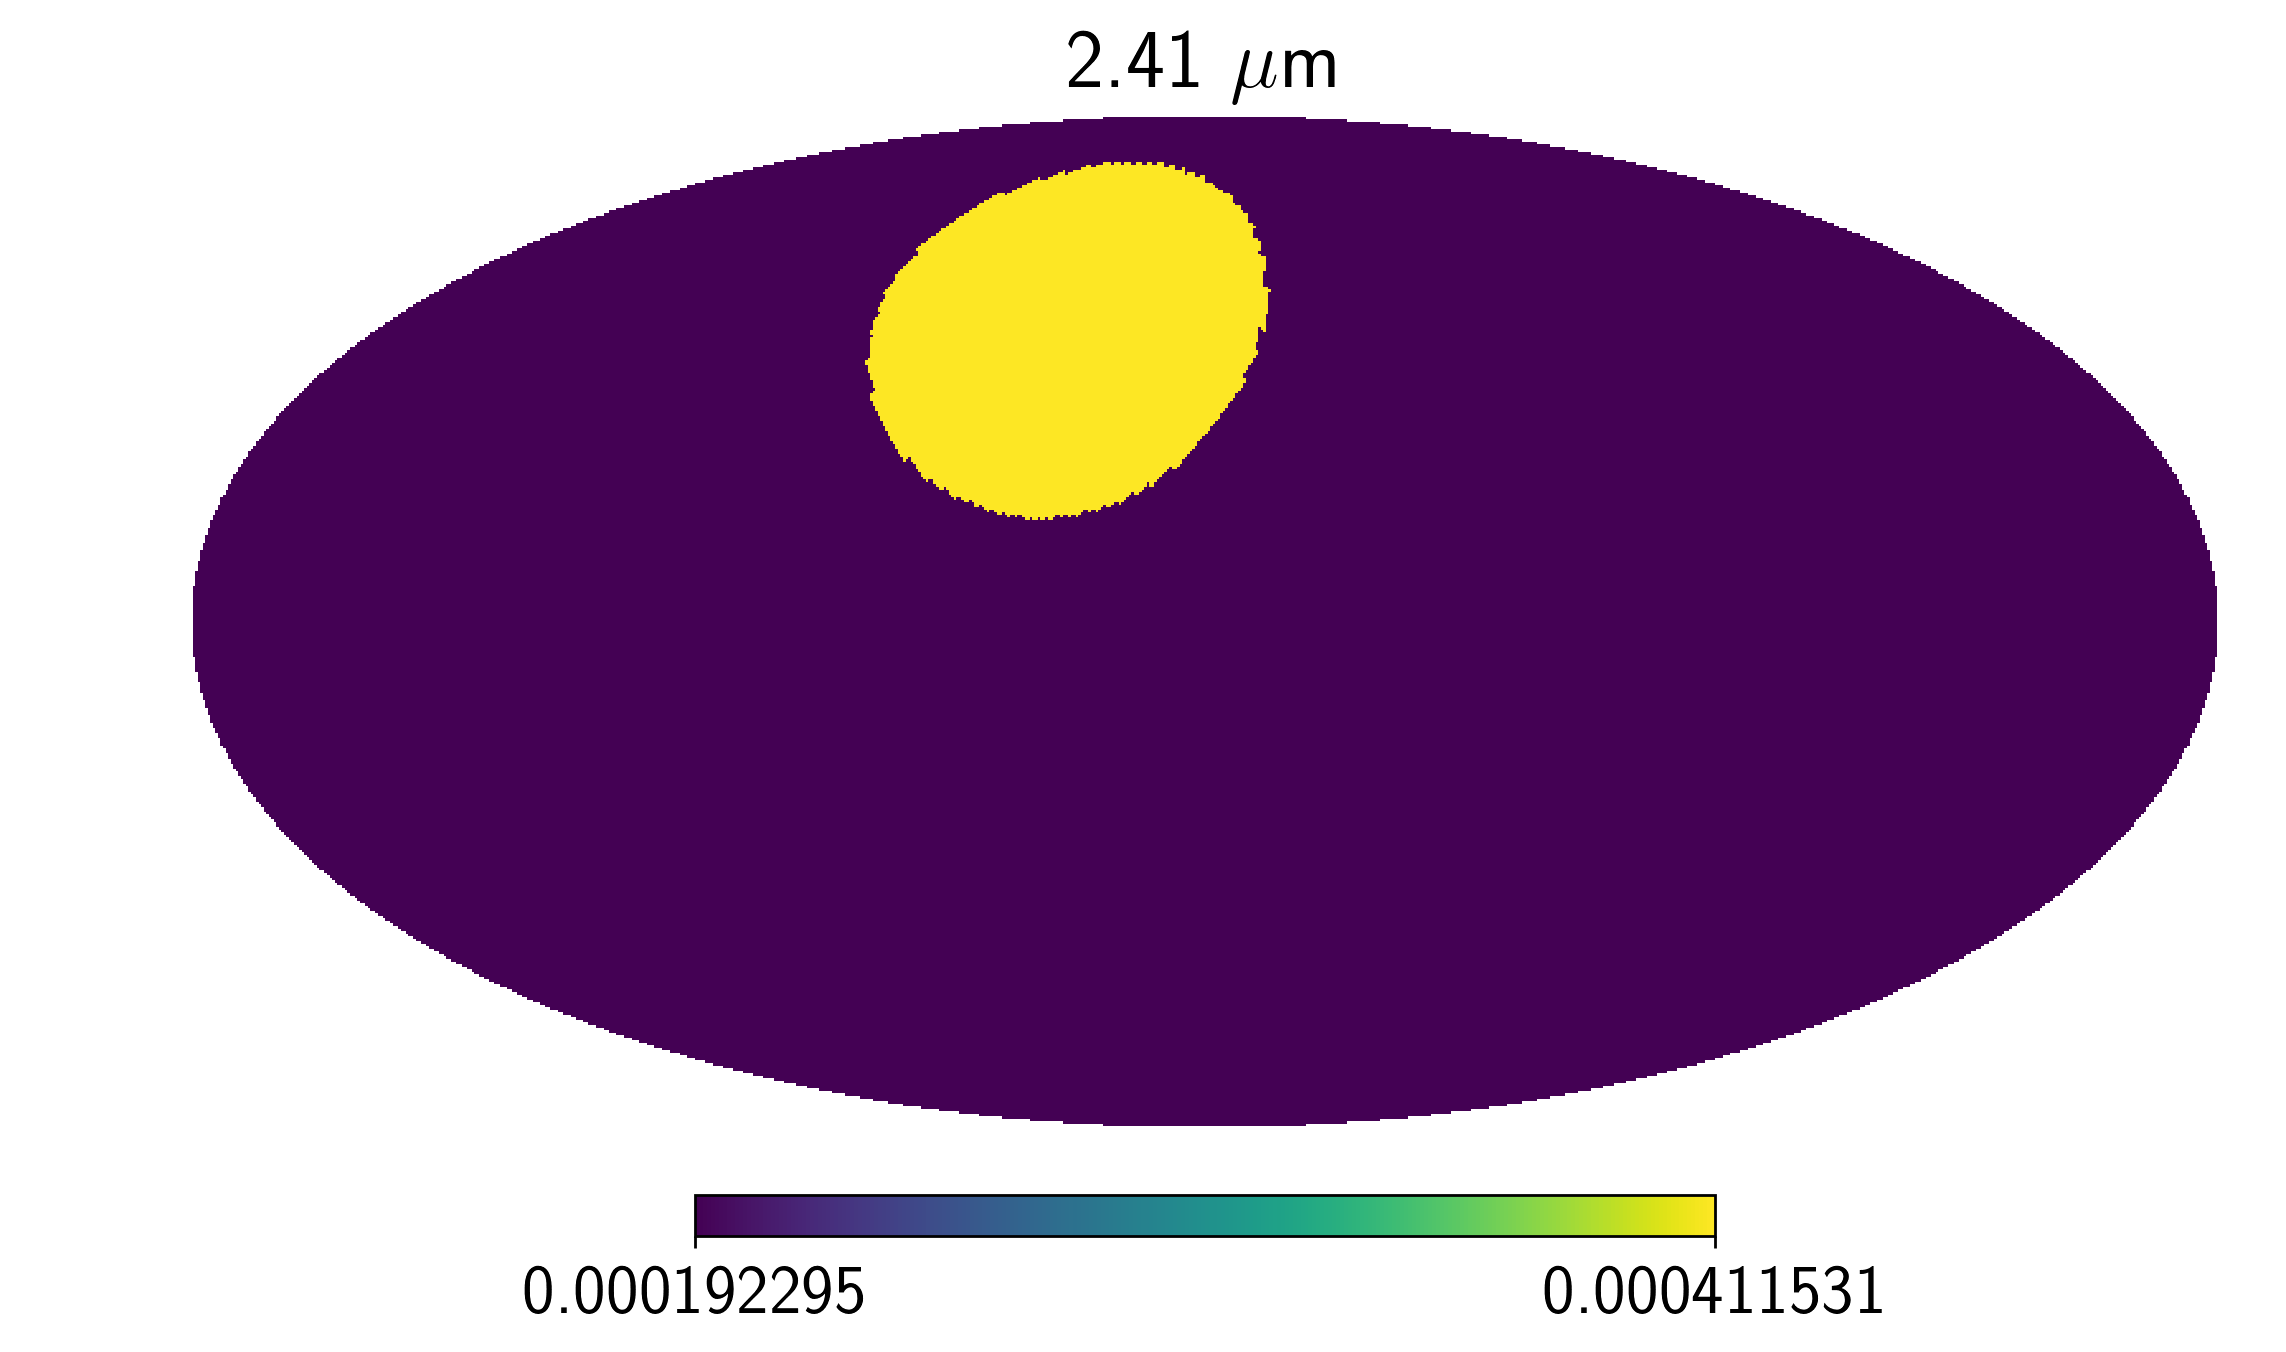

In [30]:
# Show the map
plot_utils.show_orig_map(lamhr, spaxels);

/Users/Jake/anaconda2/envs/py3/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


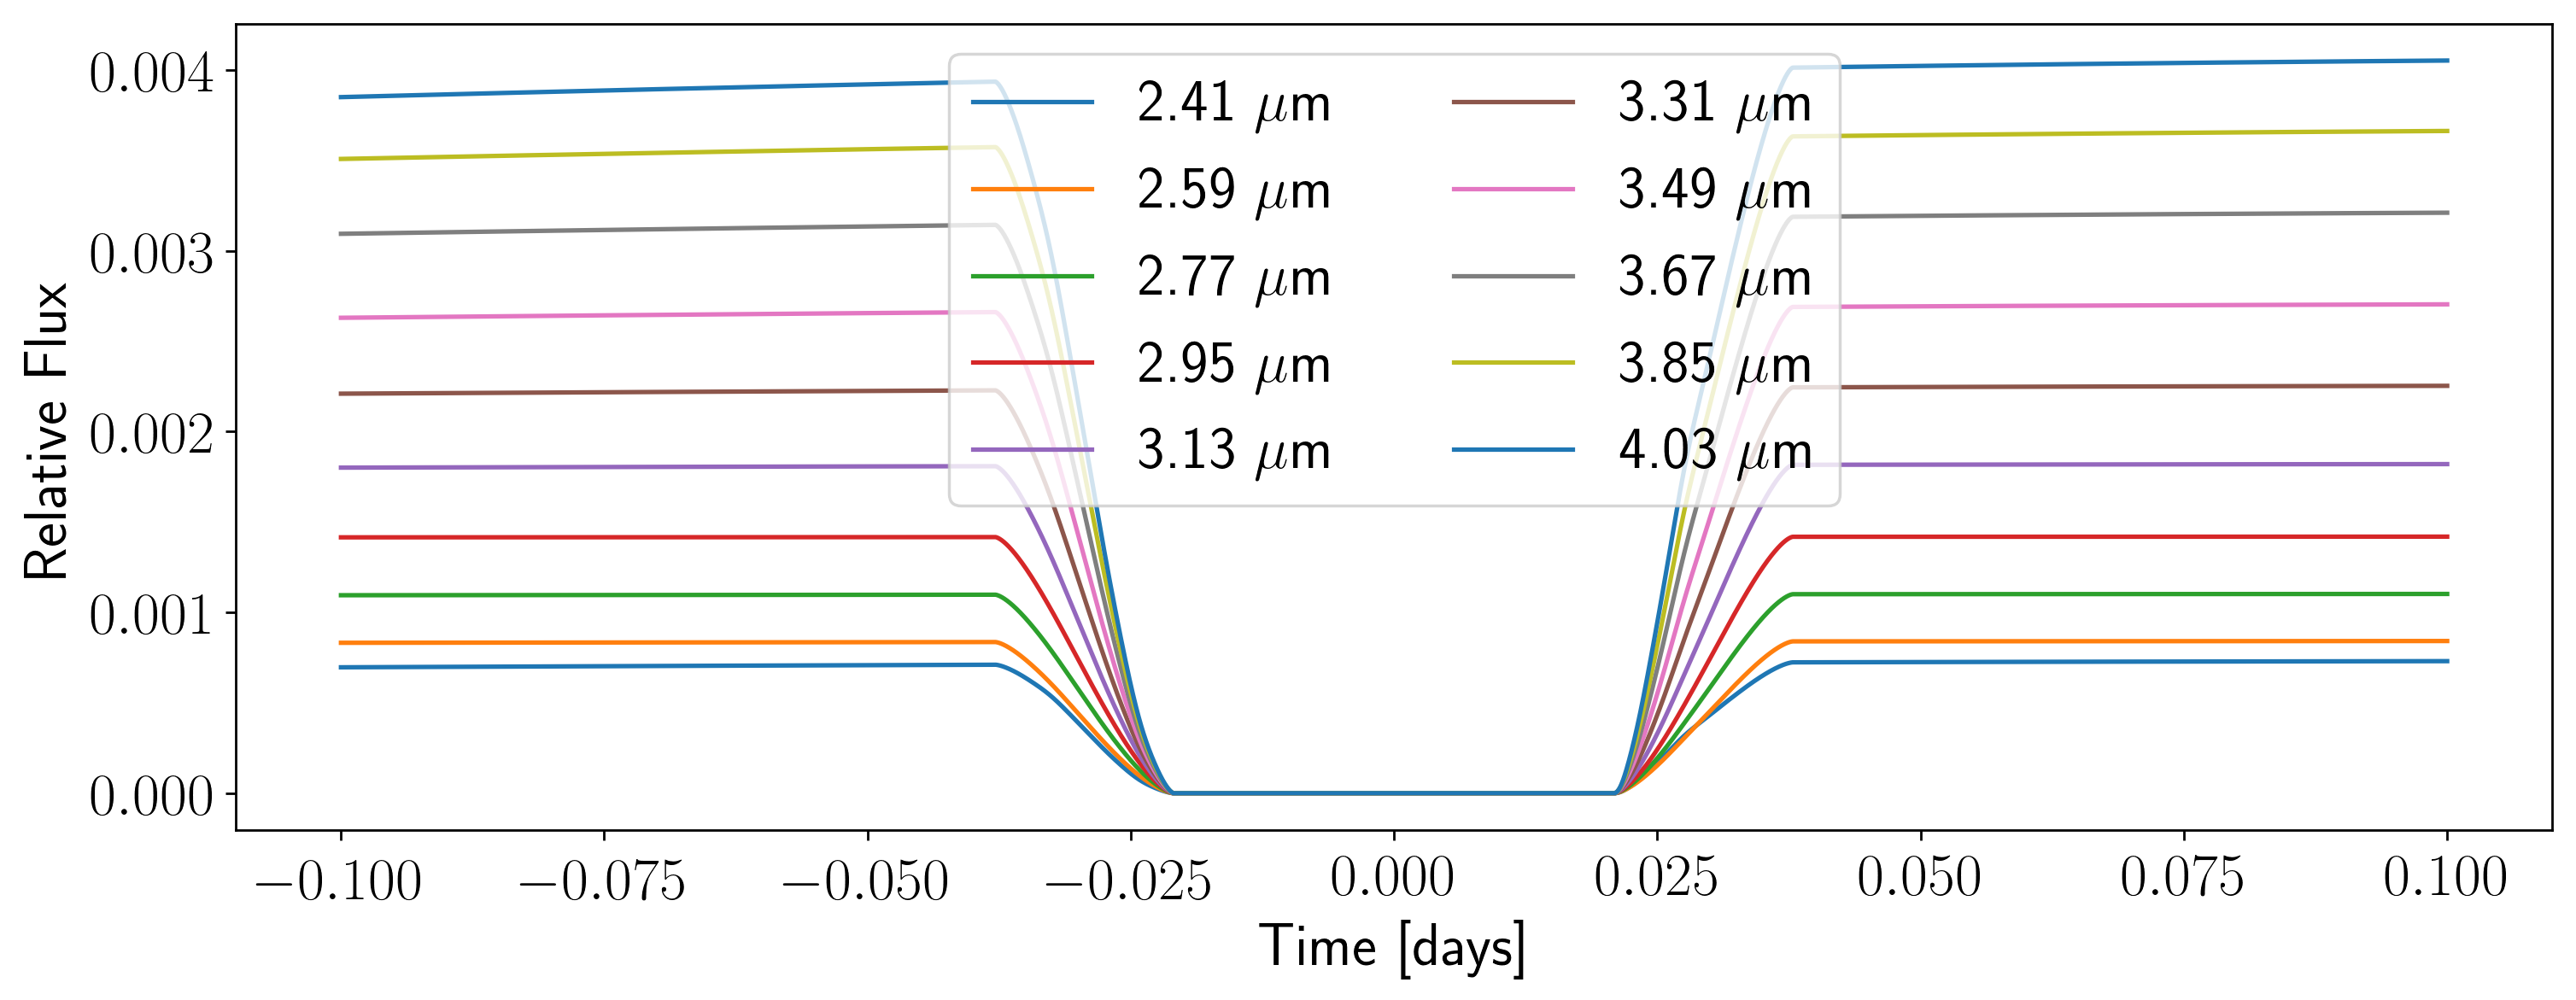

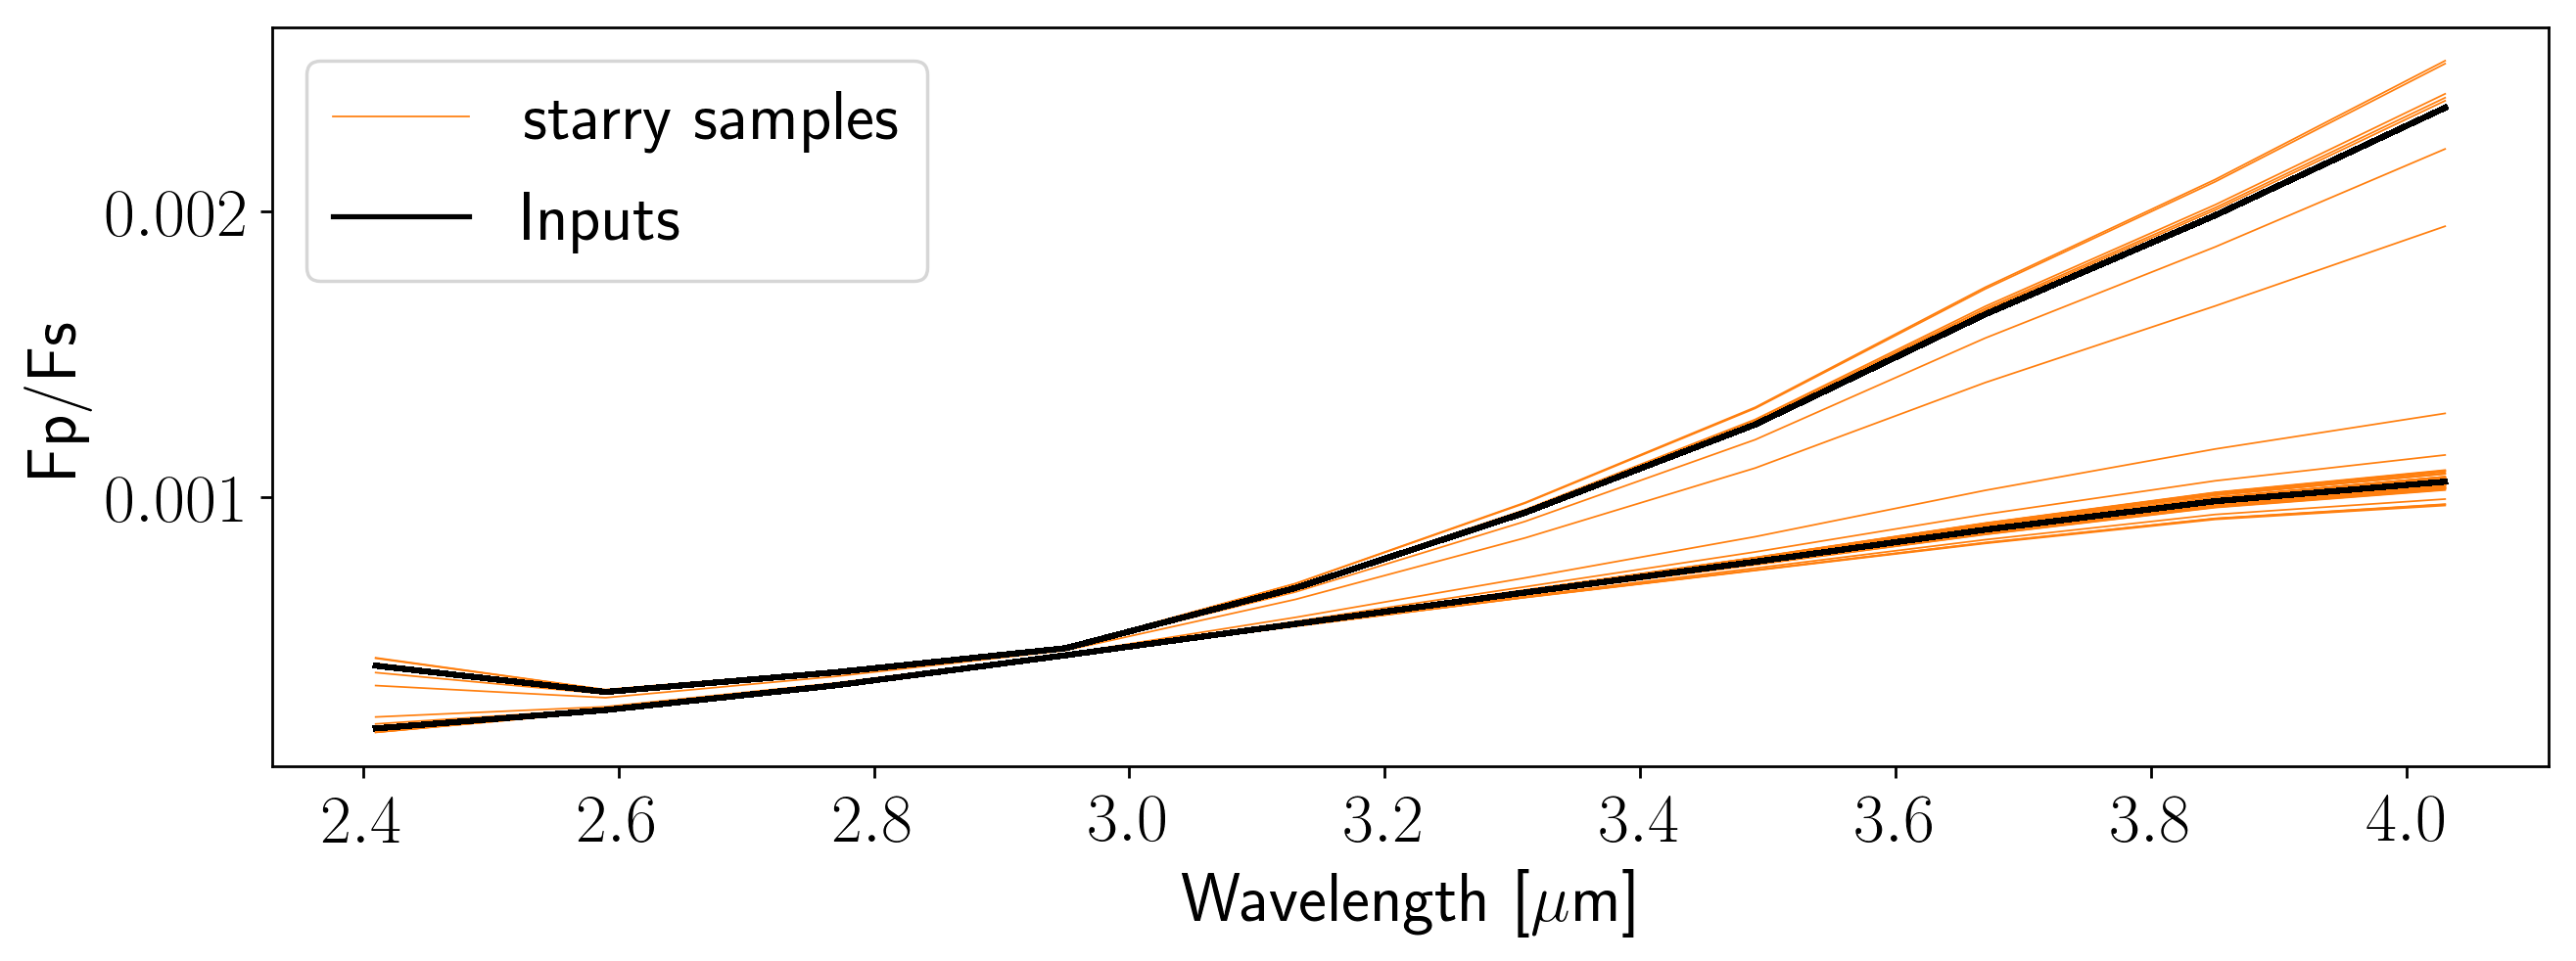

In [31]:
# Create the eclipse lightcurves
time, lam, dlam, lcurves = gen_lightcurves.create_lightcurves_with_starry(lamhr, spaxels, save_tag = "mystery2", save_output=True)

# Mystery 1: Unphysical map, Unphysical spectra <a id='one'></a>

Two-component map with offset hot spot in lat and lon, with the end-member unphysical spectra

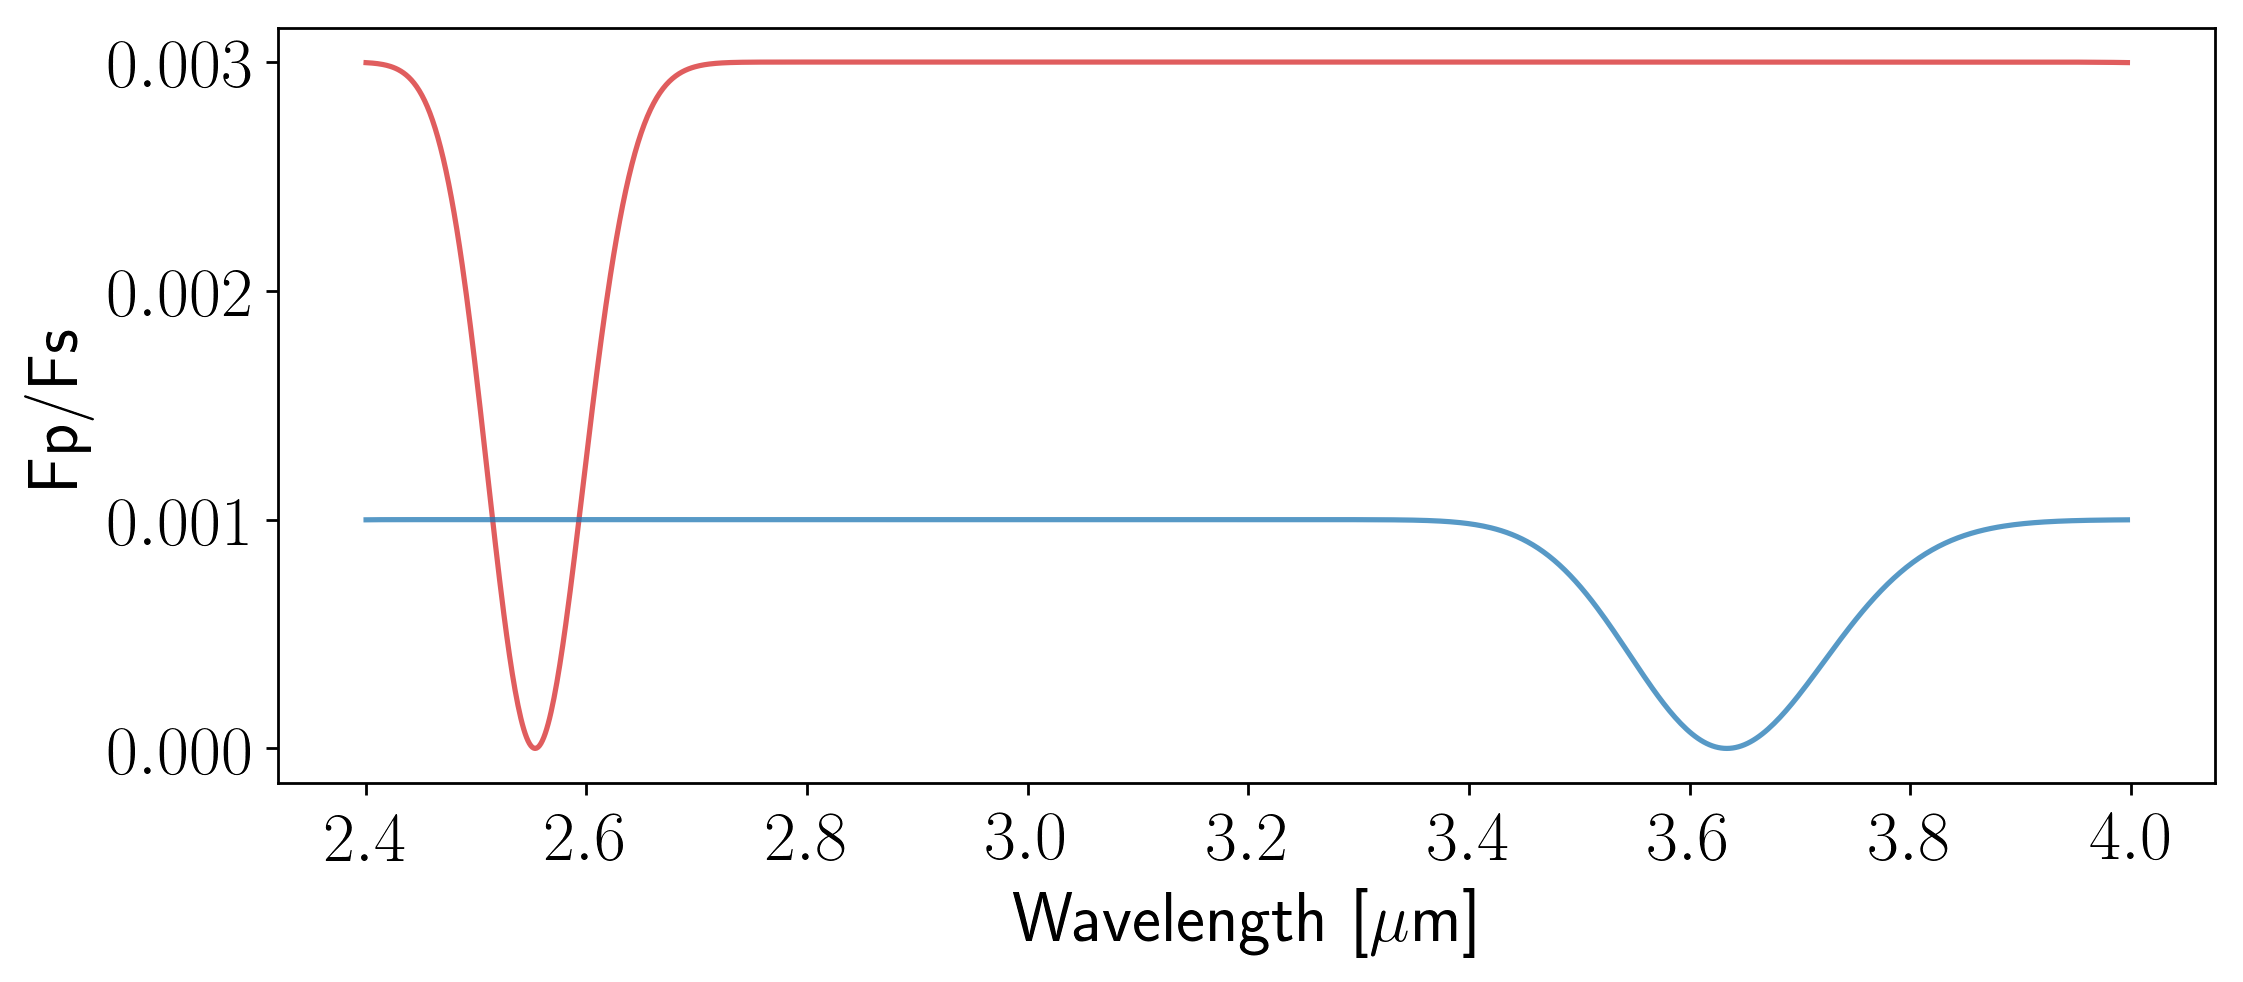

In [33]:
# Use physical spectra edge cases as the interior and exterior hot spot spectra
F_out = Ftoy[-1,:]
F_in = Ftoy[0,:]

fig, ax = plt.subplots(figsize = (10,4))
ax.set_xlabel(r"Wavelength [$\mu$m]")
ax.set_ylabel("Fp/Fs")

ax.plot(lamhr, F_in, alpha = 0.75, color = "C3")
ax.plot(lamhr, F_out, alpha = 0.75, color = "C0")

In [34]:
# Set the hotspot offset
lat0 = 45.0
lon0 = 30.0
phi0 = (lat0+180)*(np.pi / 180.) 
theta0 = lon0*(np.pi / 180.)

# Set the angular radius of the hotspot
ds = 30.0

# Create high res spectral map
spaxels = prep_two_component_hotspot_map(F_in, F_out, Nside=64, phi0=phi0, theta0=theta0, ds=30.0)

/Users/Jake/anaconda2/envs/py3/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


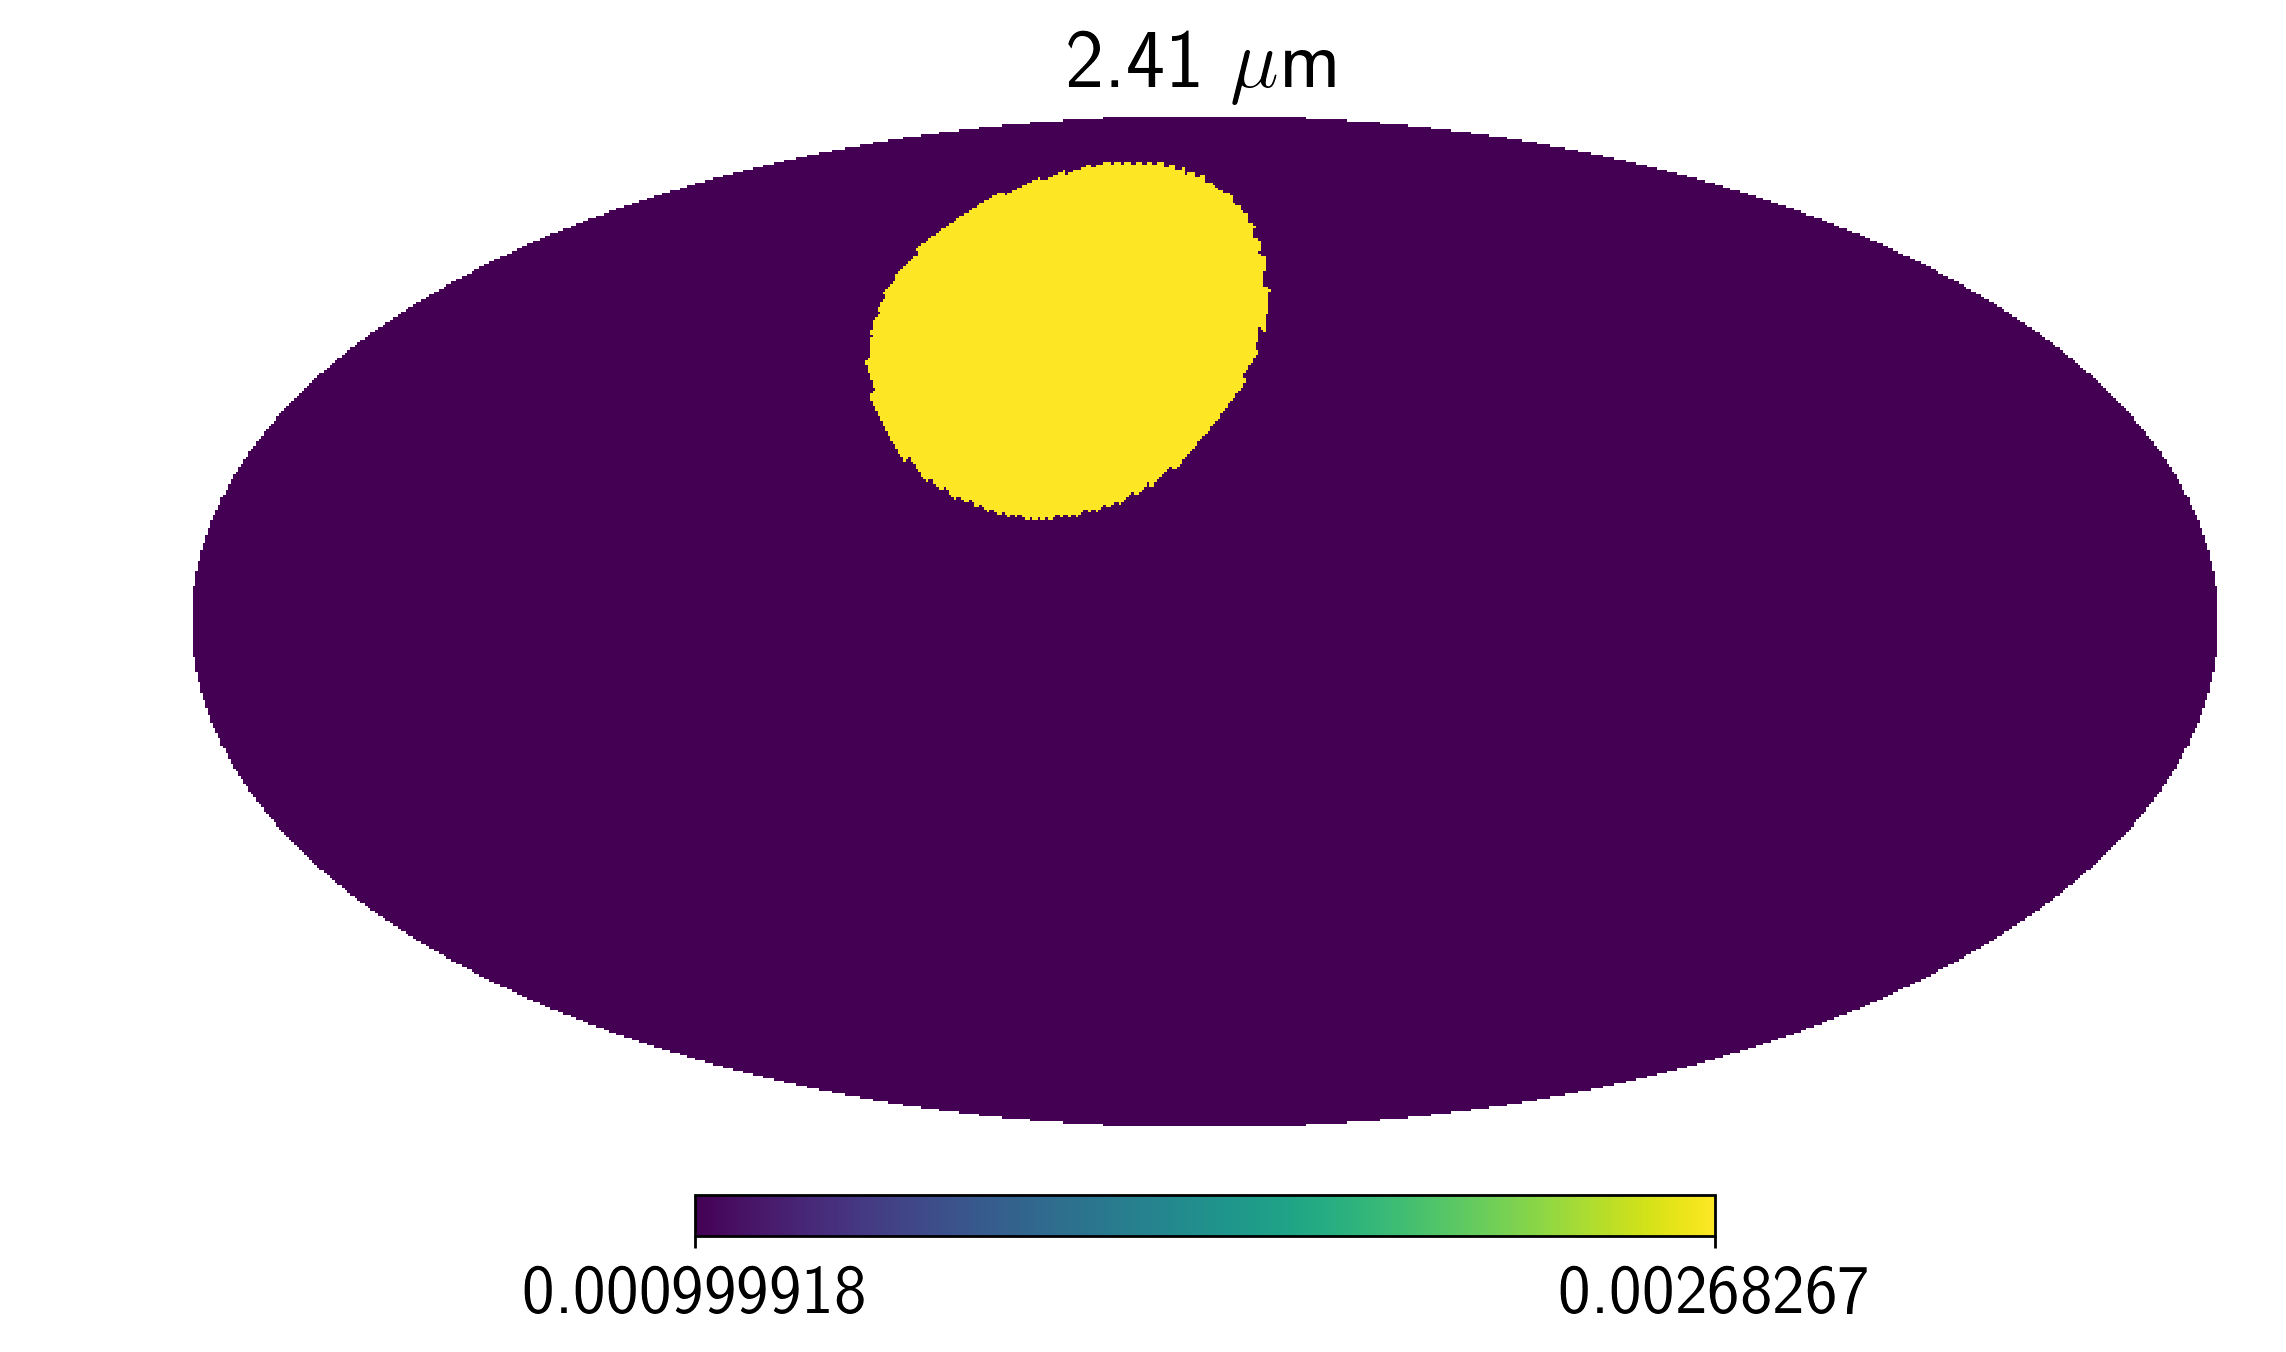

In [35]:
# Show the map
plot_utils.show_orig_map(lamhr, spaxels);

/Users/Jake/anaconda2/envs/py3/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


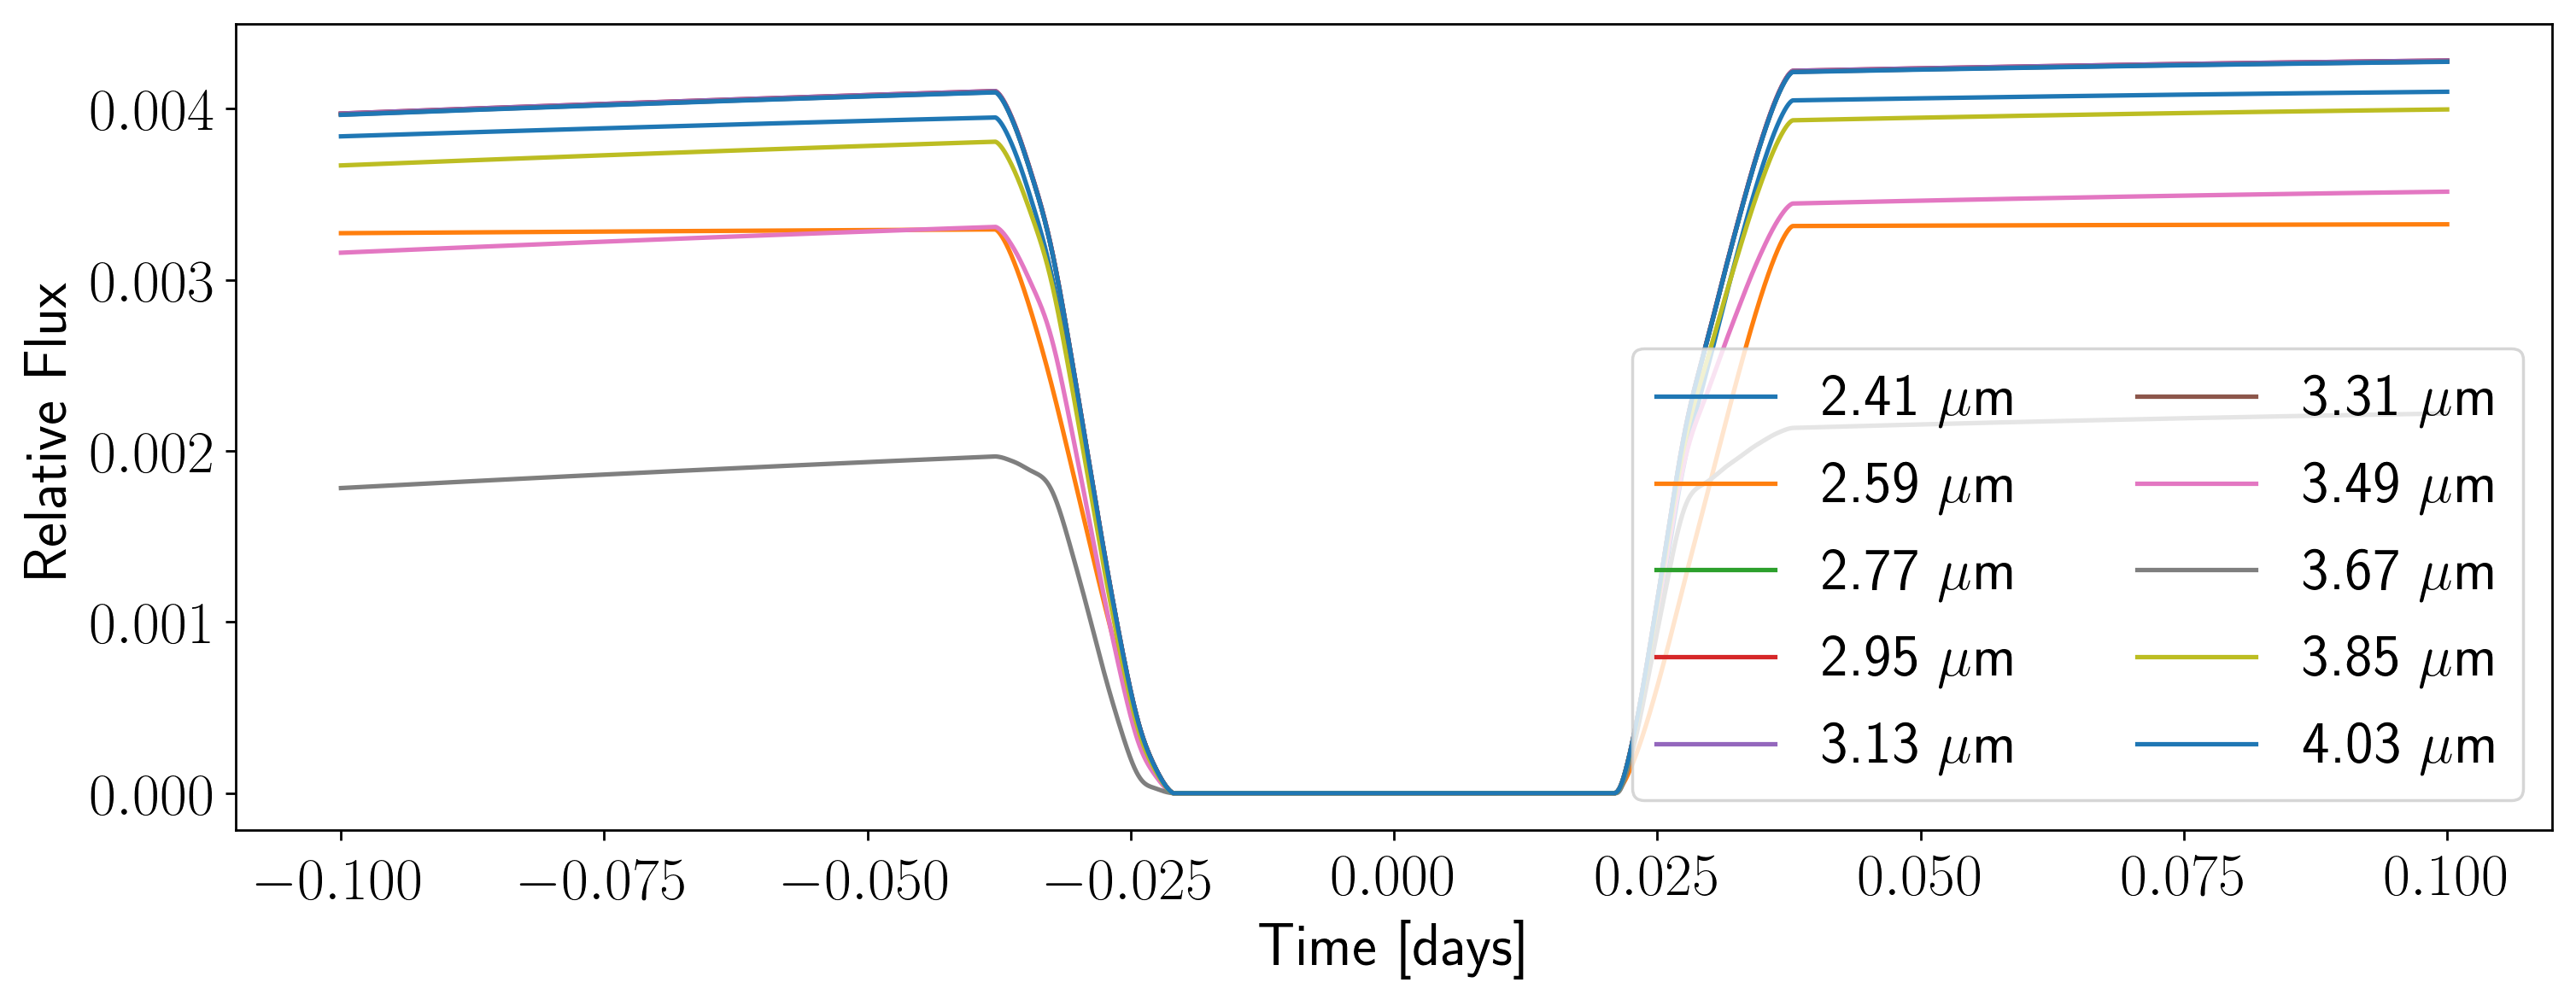

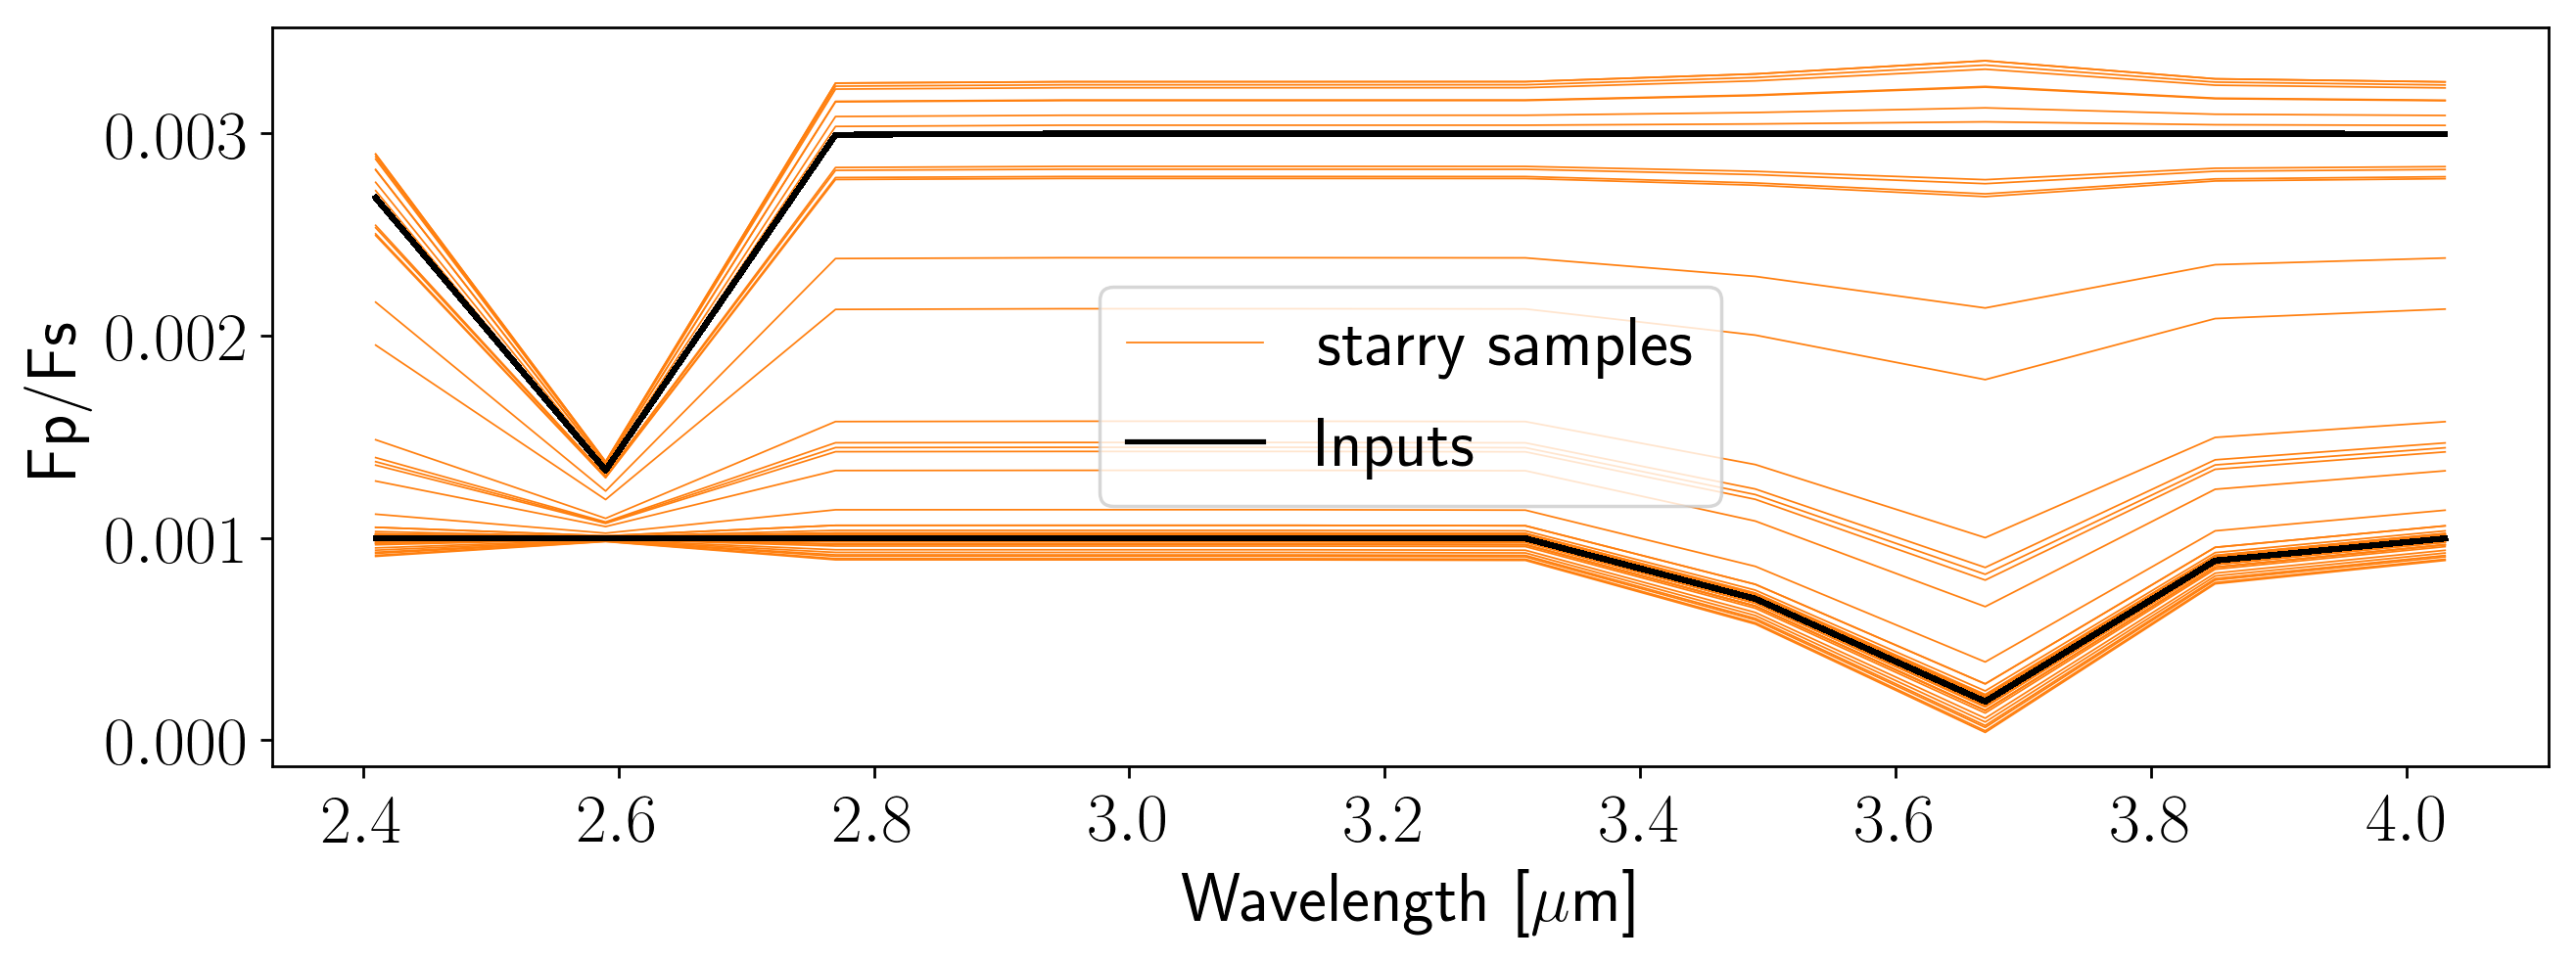

In [36]:
# Create the eclipse lightcurves
time, lam, dlam, lcurves = gen_lightcurves.create_lightcurves_with_starry(lamhr, spaxels, save_tag = "mystery1", save_output=True)

# Create Figures <a id='figures'></a>


In [18]:
from eigensource.plot_utils import create_linear_colormap

In [28]:
# Create 2d array of spectra
Fgrad_real = []  # For actual spectral data
Fgrad_fake = []  # For evenly spaced grid for map color hacking
for i in range(len(file_list)):
    data = np.load(os.path.join(path, file_list[i]))
    Fgrad_real.append(data["fpfs"])
    Fgrad_fake.append(i*np.ones_like(data["fpfs"]))
Fgrad_real = np.array(Fgrad_real)[::-1, :]
Fgrad_fake = np.array(Fgrad_fake)[::-1, :]
wl = data["wl"]

In [29]:
# Create high res spectral map
lamhr, spaxels = prep_gradient_hotspot_map(wl, Fgrad_fake, ds = 89.0, Nside=64)

/Users/Jake/anaconda2/envs/py3/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


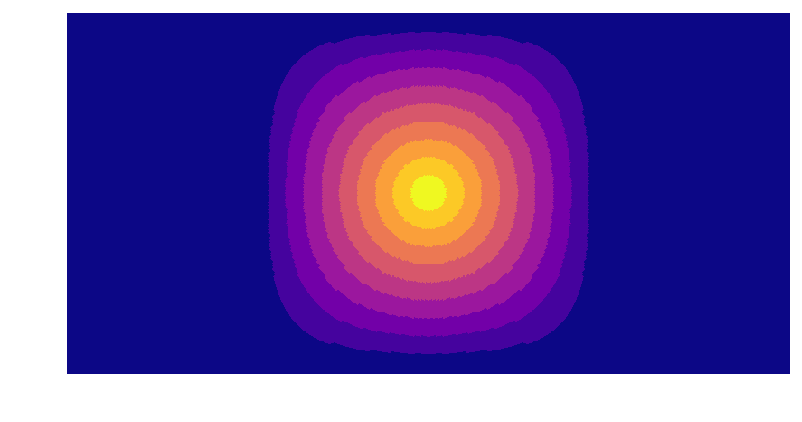

In [30]:
#origData = np.load("data/maps/mystery_map{}.npz".format(testNum))
lammin1 = 2.41; lammax1 = 3.98; dlam1 = 0.18
#spaxels = origData["spaxels"]
#lam = origData["wl"]
lamlo, dlamlo = gen_lightcurves.construct_lam(lammin1, lammax1, dlam=dlam1)
Nlamlo = len(lamlo)

# Set HealPy pixel numbers
Npix = spaxels.shape[0]

# Define empty 2d array for spaxels
spec2d = np.zeros((Npix, Nlamlo))

# Loop over pixels filling with spectra
for i in range(Npix):
    # Degrade the spectra to lower resolution
    spec2d[i,:] = gen_lightcurves.downbin_spec(spaxels[i, :], lamhr, lamlo, dlam = dlamlo)


waveInd = 0
x = hp.cartview(spec2d[:,waveInd], title="", cbar=False, cmap=plt.cm.plasma, lonra=[-180,180], latra=[-90,90], notext=False, 
            return_projected_map = True)



In [31]:
# Copied from hot spot notebook
data_extent = (-180, 180, -90, 90)
full_extent = np.array([-106.22662706,  106.22662706,  -90.        ,   90.        ])

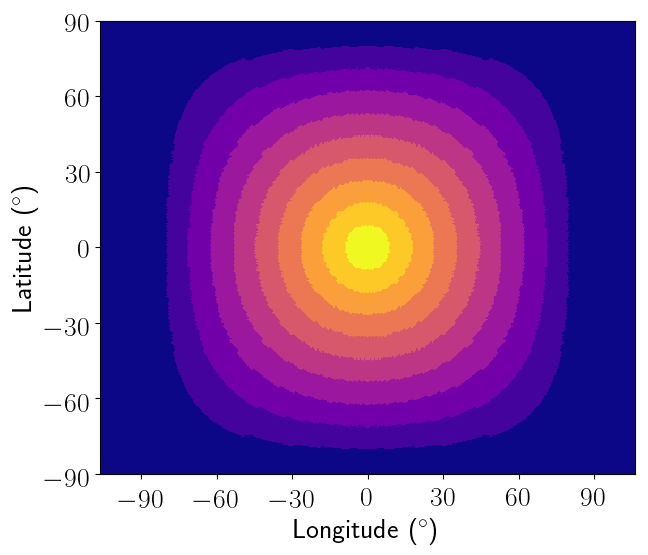

In [32]:
fig, ax = plt.subplots(figsize = (8,6))
ax.imshow(x, origin="lower", extent = data_extent, cmap=plt.cm.plasma, aspect="equal")
ax.set_ylabel("Latitude ($^{\circ}$)")
ax.set_xlabel("Longitude ($^{\circ}$)")
#ax.set_xticks([-180, -90, 0, 90, 180])
ax.set_xlim(full_extent[0], full_extent[1])
ax.set_ylim(full_extent[2], full_extent[3])
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90])
ax.set_xticks([-90, -60, -30, 0, 30, 60, 90])

In [42]:
# Create high res spectral map
lamhr, spaxels = prep_gradient_hotspot_map(wl, Fgrad_real, ds = 89.0, Nside=64)

#origData = np.load("data/maps/mystery_map{}.npz".format(testNum))
lammin1 = 2.41; lammax1 = 3.98; dlam1 = 0.18
#spaxels = origData["spaxels"]
#lam = origData["wl"]
lamlo, dlamlo = gen_lightcurves.construct_lam(lammin1, lammax1, dlam=dlam1)

/Users/Jake/anaconda2/envs/py3/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


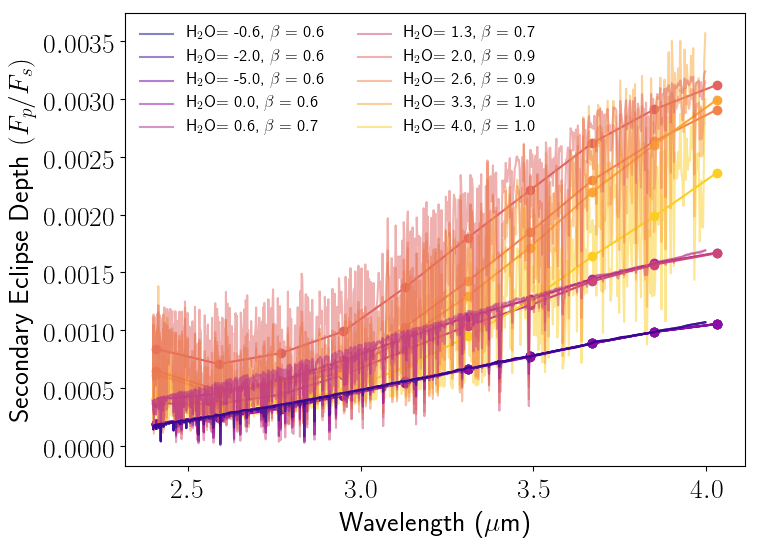

In [45]:
fig, ax = plt.subplots(figsize = (8,6))
ax.set_xlabel("Wavelength ($\mu$m)")
ax.set_ylabel("Secondary Eclipse Depth $(F_p / F_s)$")

COLORS = plt.cm.plasma(np.arange(len(file_list)) / float(len(file_list)))
for i in range(len(file_list)):
    data = np.load(os.path.join(path, file_list[i]))
    ax.plot(data["wl"], data["fpfs"], alpha = 0.5, color = COLORS[i], zorder = len(file_list) - i, label = "%s" %file_list[i].replace("_", " ").replace(".npz", "").replace("h2o", r"H$_2$O=").replace(" beta", r", $\beta=$"))
    speclo = gen_lightcurves.downbin_spec(data["fpfs"], data["wl"], lamlo, dlam = dlamlo)
    ax.plot(lamlo, speclo, "-o", color = COLORS[i], alpha = 1.0)
ax.legend(ncol = 2, fontsize = 12, framealpha = 0.0)

/Users/Jake/anaconda2/envs/py3/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


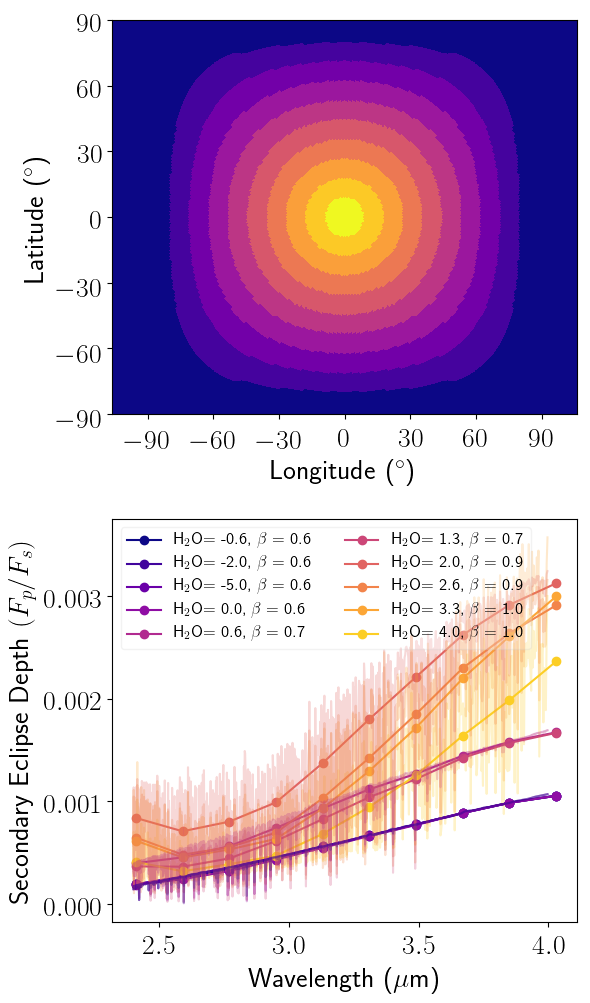

In [55]:
fig, ax = plt.subplots(2,1, figsize = (6, 12), gridspec_kw={"hspace" : 0.25})

ax[0].imshow(x, origin="lower", extent = data_extent, cmap=plt.cm.plasma, aspect="equal")
ax[0].set_ylabel("Latitude ($^{\circ}$)")
ax[0].set_xlabel("Longitude ($^{\circ}$)")
ax[0].set_xlim(full_extent[0], full_extent[1])
ax[0].set_ylim(full_extent[2], full_extent[3])
ax[0].set_yticks([-90, -60, -30, 0, 30, 60, 90])
ax[0].set_xticks([-90, -60, -30, 0, 30, 60, 90])

ax[1].set_xlabel("Wavelength ($\mu$m)")
ax[1].set_ylabel("Secondary Eclipse Depth $(F_p / F_s)$")
COLORS = plt.cm.plasma(np.arange(len(file_list)) / float(len(file_list)))
for i in range(len(file_list)):
    data = np.load(os.path.join(path, file_list[i]))
    ax[1].plot(data["wl"], data["fpfs"], alpha = 0.25, color = COLORS[i], zorder = len(file_list) - i)
    speclo = gen_lightcurves.downbin_spec(data["fpfs"], data["wl"], lamlo, dlam = dlamlo)
    ax[1].plot(lamlo, speclo, "-o", color = COLORS[i], alpha = 1.0, label = "%s" %file_list[i].replace("_", " ").replace(".npz", "").replace("h2o", r"H$_2$O=").replace(" beta", r", $\beta=$"))
ax[1].legend(ncol = 2, fontsize = 12, framealpha = 0.25)

#fig.tight_layout()
fig.savefig("plots/paper_figures/continuum_hotspot_inputs.png", bbox_inches = "tight")